Project #5: Video Stitching and Processing 

## CS445: Computational Photography - Spring 2020

### Setup


In [1]:
import cv2

In [2]:
#!pip uninstall opencv-python 
# downgrade OpenCV a bit to use SIFT
#!pip install opencv-contrib-python==3.4.2.17 --force-reinstall
#!pip install ffmpeg-python  
 
import ffmpeg
import cv2
import numpy as np
import os
from numpy.linalg import svd, inv
import utils
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
# modify to where you store your project data including utils
datadir = r"C:\Users\ijise\Desktop\cs445\project5\proj5\mp5"


""" utilfn = datadir + "utils.py"
!cp "$utilfn" .
imagesfn = datadir + "images"
!cp -r "$imagesfn" . """
 

utilfn = os.path.join(datadir, "utils")
imagesfn = os.path.join(datadir, "imagesfn")

### Part I: Stitch two key frames 

#### This involves:
1. compute homography H between two frames; 
2. project each frame onto the same surface;
3. blend the surfaces.

Check that your homography is correct by plotting four points that form a square in frame 270 and their projections in each image.

In [4]:
def score_projection(pt1, pt2):
  '''
  Score corresponding to the number of inliers for RANSAC
  Input: pt1 and pt2 are 2xN arrays of N points such that pt1[:, i] and pt2[:,i] should be close in Euclidean distance if they are inliers
  Outputs: score (scalar count of inliers) and inliers (1xN logical array)
  '''

  # TO DO
  distance = np.linalg.norm(pt1 - pt2, axis=0)
  inliers = distance < 5
  score = np.sum(inliers)
  return score, inliers


def auto_homography(Ia,Ib, homography_func=None,normalization_func=None):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)    
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
   
    numMatches = int(len(good))

    matches = good

    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 1000
    best_score = 0
    n_to_sample = 4 # Put the correct number of points here

    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, n_to_sample, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]
        
        H_t = homography_func(pts1, pts2, normalization_func) # edit helper code below (computeHomography)
        

        
        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        Xb_ /= Xb_[2, :]
        
        score_t, inliers_t = score_projection(Xb[:2,:]/Xb[2,:], Xb_[:2,:]/Xb_[2,:])

        if score_t > best_score:
            best_score = score_t
            H = H_t
            in_idx = inliers_t
    
    print('best score: {:02f}'.format(best_score))

    # Optionally, you may want to re-estimate H based on inliers


    return H

In [5]:
def computeHomography(pts1, pts2,normalization_func=None):
    '''
    Compute homography that maps from pts1 to pts2 using SVD. Normalization is optional.
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    # TO DO
    if normalization_func:
        pts1, T1 = normalization_func(pts1)  # Normalize pts1
        pts2, T2 = normalization_func(pts2)  # Normalize pts2
    else:
        T1 = T2 = np.eye(3)


    N = pts1.shape[1]
    A = []

    for i in range(N):
        x, y, w = pts1[:, i]
        u, v, s = pts2[:, i]
        
        A.append([-x, -y, -w, 0, 0, 0, u * x, u * y, u * w])
        A.append([0, 0, 0, -x, -y, -w, v * x, v * y, v * w])

    A = np.array(A)

    #  SVD
    U, S, V = np.linalg.svd(A)
    H = V[-1].reshape(3, 3)  

    # denormalize
    H = np.dot(np.linalg.inv(T2), np.dot(H, T1)) 
    H /= H[-1, -1] 

    return H

best score: 222.000000
[[ 1.00000000e+00  2.39428491e-02 -2.01157844e+02]
 [ 3.39268464e-03  9.47916328e-01 -1.08122707e+01]
 [ 2.74321977e-04 -9.70410941e-06  8.69690036e-01]]


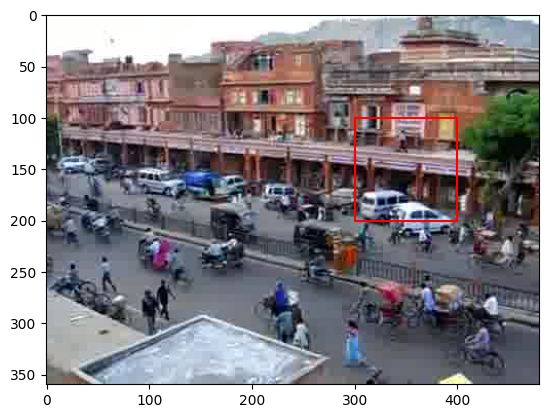

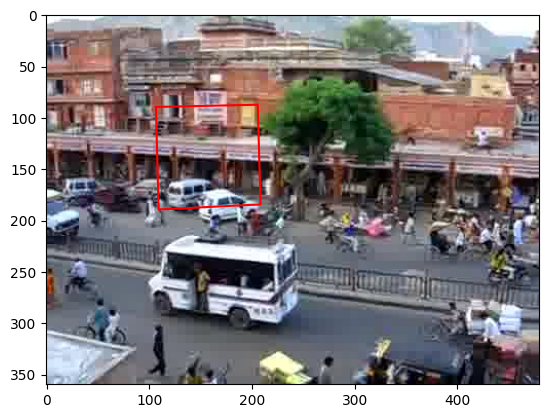

In [6]:
# images location
im1 = './images/input/frames/f0270.jpg'
im2 = './images/input/frames/f0450.jpg'

# Load an color image in grayscale
im1 = cv2.imread(im1)
im2 = cv2.imread(im2)

H = auto_homography(im1,im2, computeHomography)
print(H/H.max()) 

# plot the frames here
box_pts = np.array([[300, 400, 400, 300, 300], [100, 100, 200, 200, 100], [1, 1, 1, 1, 1]])
plt.figure()
plt.imshow(im1[:,:,[2,1,0]])
plt.plot(box_pts[0,:], box_pts[1, :], 'r-')

# TO DO: project points into im2 and display the projected lines on im2

box_pts2 = np.dot(H, box_pts)
box_pts2 /= box_pts2[2, :]

plt.figure()
plt.imshow(im2[:,:,[2,1,0]])
plt.plot(box_pts2[0, :], box_pts2[1, :], 'r-')



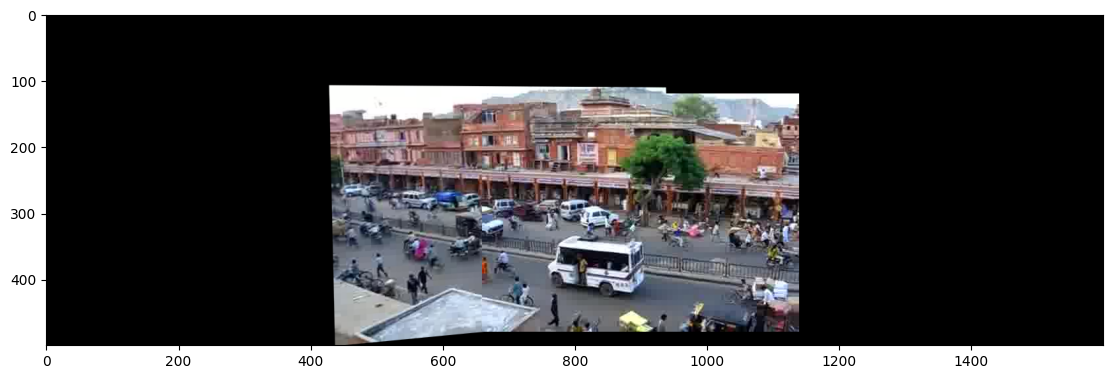

In [7]:
projectedWidth = 1600
projectedHeight = 500
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])

# TO DO: warp and blend the two images

warp = cv2.warpPerspective(im1, np.dot(Tr, H), (projectedWidth, projectedHeight))
warp[Tr[1,2]:Tr[1,2]+im2.shape[0], Tr[0,2]:Tr[0,2]+im2.shape[1],:] = im2
blend = warp

plt.figure(figsize=(30,30))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(blend, cv2.COLOR_BGR2RGB))



### Part II: Panorama using five key frames

Produce a panorama by mapping five key frames [90, 270, 450, 630, 810] onto the same reference frame 450.  


best score: 254.000000
best score: 234.000000
best score: 209.000000
best score: 139.000000


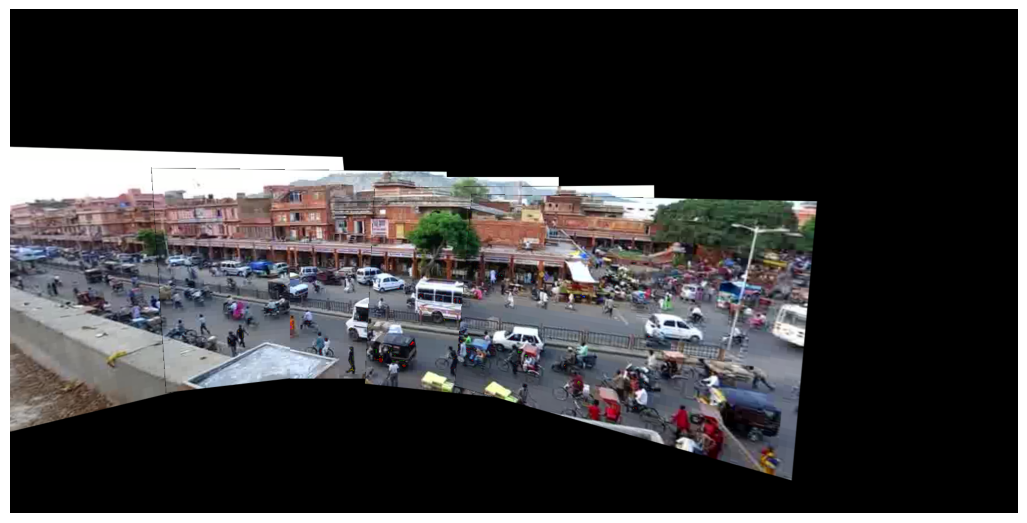

In [ ]:
key_frames_idx = np.array([90, 270, 450, 630, 810])-1

frames = np.zeros((len(key_frames_idx), im1.shape[0], im1.shape[1], im1.shape[2]),dtype='uint8')
for n in range(len(key_frames_idx)):
  frames[n] = cv2.cvtColor(
    cv2.imread(f"./images/input/frames/f0{str(key_frames_idx[n]+1).zfill(3)}.jpg"), 
    cv2.COLOR_BGR2RGB
)


# TO DO solution

frame1 = auto_homography(frames[0], frames[1], computeHomography)
frame2 = auto_homography(frames[1], frames[2], computeHomography)
frame3 = auto_homography(frames[3], frames[2], computeHomography)
frame4 = auto_homography(frames[4], frames[3], computeHomography)

frame1 = np.dot(frame2, frame1) 
frame4 = np.dot(frame3, frame4)

tr = np.array([[1, 0, 500], [0, 1, 300], [0, 0, 1]])


homographies = [np.dot(tr, frame1), np.dot(tr, frame2), np.dot(tr, np.eye(3)), np.dot(tr, frame3), np.dot(tr, frame4)]

projectedWidth = 1800 
projectedHeight = 900
res = np.zeros((projectedHeight, projectedWidth, 3), dtype=np.uint8)

for i, frame in enumerate(frames):
    warped_frame = cv2.warpPerspective(frame, homographies[i], (projectedWidth, projectedHeight))
    warped_frame = np.clip(warped_frame, 0, 255).astype('uint8')
    res = np.where(warped_frame > 0, warped_frame, res) 

plt.figure(figsize=(13, 8))
plt.imshow(res)
plt.axis('off')
plt.show()


### Part 3: Map the video to the reference plane

Project each frame onto the reference frame (using same size panorama) to create a video that shows the portion of the panorama revealed by each frame

In [ ]:
# read all the images
import os 
dir_frames = 'images/input/frames'
filenames = []
filesinfo = os.scandir(dir_frames)

filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype='uint8')

for idx, file_i in enumerate(filenames):
  frames[idx] = cv2.cvtColor(cv2.imread(file_i), cv2.COLOR_BGR2RGB)



In [ ]:
print("Frames shape:", frames.shape)
print("Key frame indices:", key_frames_idx)


Frames shape: (900, 360, 480, 3)
Key frame indices: [ 89 269 449 629 809]


In [ ]:
import numpy as np
import cv2
import os
from tqdm import tqdm


projectedWidth = 1600
projectedHeight = 500
key_frames_idx = np.array([90, 270, 450, 630, 810]) - 1
reference_idx = 450 - 1 
Tr = np.array([
    [1, 0, 500],
    [0, 1, 50],
    [0, 0, 1]
])

homography_dir = "homographies"
frames_dir = "warped_frames"
os.makedirs(homography_dir, exist_ok=True)
os.makedirs(frames_dir, exist_ok=True)

frame_files = sorted(os.listdir("images/input/frames"), key=lambda x: int(''.join(filter(str.isdigit, x))))
frames = [cv2.imread(f"images/input/frames/{frame}") for frame in frame_files]
frameCount = len(frames)

homographies = []
for i in tqdm(range(frameCount)):
    if i == reference_idx:
        homography = np.eye(3)  
    elif i < reference_idx:
        temp_homography = auto_homography(frames[i], frames[key_frames_idx[1]], computeHomography)
        second_homography = auto_homography(frames[key_frames_idx[1]], frames[reference_idx], computeHomography)
        homography = np.dot(second_homography, temp_homography)
    else:
        temp_homography = auto_homography(frames[i], frames[key_frames_idx[3]], computeHomography)
        second_homography = auto_homography(frames[key_frames_idx[3]], frames[reference_idx], computeHomography)
        homography = np.dot(second_homography, temp_homography)

    homography = np.dot(Tr, homography)
    homographies.append(homography)
    np.save(f"{homography_dir}/homography_{i:04d}.npy", homography)

for i in tqdm(range(frameCount)):
    t_frame = cv2.warpPerspective(frames[i], homographies[i], (projectedWidth, projectedHeight))
    cv2.imwrite(f"{frames_dir}/frame_{i:04d}.jpg", t_frame)

utils.imageFolder2mpeg(input_path=frames_dir, output_path='./part3_video.mpeg')


  0%|          | 0/900 [00:00<?, ?it/s]

best score: 197.000000


  0%|          | 1/900 [00:00<09:37,  1.56it/s]

best score: 222.000000
best score: 194.000000


  0%|          | 2/900 [00:01<09:31,  1.57it/s]

best score: 221.000000
best score: 207.000000


  0%|          | 3/900 [00:01<08:31,  1.75it/s]

best score: 222.000000
best score: 190.000000


  0%|          | 4/900 [00:02<08:14,  1.81it/s]

best score: 222.000000
best score: 215.000000


  1%|          | 5/900 [00:02<08:04,  1.85it/s]

best score: 222.000000
best score: 215.000000


  1%|          | 6/900 [00:03<07:48,  1.91it/s]

best score: 222.000000
best score: 225.000000


  1%|          | 7/900 [00:03<07:55,  1.88it/s]

best score: 221.000000
best score: 216.000000


  1%|          | 8/900 [00:04<08:11,  1.82it/s]

best score: 222.000000
best score: 221.000000


  1%|          | 9/900 [00:04<07:57,  1.86it/s]

best score: 222.000000
best score: 224.000000


  1%|          | 10/900 [00:05<07:43,  1.92it/s]

best score: 222.000000
best score: 222.000000


  1%|          | 11/900 [00:05<07:31,  1.97it/s]

best score: 222.000000
best score: 236.000000


  1%|▏         | 12/900 [00:06<07:23,  2.00it/s]

best score: 222.000000
best score: 227.000000


  1%|▏         | 13/900 [00:06<07:13,  2.05it/s]

best score: 221.000000
best score: 244.000000


  2%|▏         | 14/900 [00:07<07:16,  2.03it/s]

best score: 221.000000
best score: 228.000000


  2%|▏         | 15/900 [00:07<07:10,  2.05it/s]

best score: 222.000000
best score: 225.000000


  2%|▏         | 16/900 [00:08<07:05,  2.08it/s]

best score: 221.000000
best score: 238.000000


  2%|▏         | 17/900 [00:08<07:02,  2.09it/s]

best score: 222.000000
best score: 229.000000


  2%|▏         | 18/900 [00:09<07:04,  2.08it/s]

best score: 221.000000
best score: 224.000000


  2%|▏         | 19/900 [00:09<07:26,  1.97it/s]

best score: 221.000000
best score: 222.000000


  2%|▏         | 20/900 [00:10<07:28,  1.96it/s]

best score: 221.000000
best score: 225.000000


  2%|▏         | 21/900 [00:10<07:24,  1.98it/s]

best score: 222.000000
best score: 219.000000


  2%|▏         | 22/900 [00:11<07:16,  2.01it/s]

best score: 222.000000
best score: 228.000000


  3%|▎         | 23/900 [00:11<07:17,  2.00it/s]

best score: 221.000000
best score: 228.000000


  3%|▎         | 24/900 [00:12<07:18,  2.00it/s]

best score: 221.000000
best score: 221.000000


  3%|▎         | 25/900 [00:12<07:11,  2.03it/s]

best score: 221.000000
best score: 229.000000


  3%|▎         | 26/900 [00:13<07:07,  2.05it/s]

best score: 221.000000
best score: 224.000000


  3%|▎         | 27/900 [00:13<07:01,  2.07it/s]

best score: 222.000000
best score: 233.000000


  3%|▎         | 28/900 [00:14<07:02,  2.06it/s]

best score: 222.000000
best score: 240.000000


  3%|▎         | 29/900 [00:14<07:02,  2.06it/s]

best score: 220.000000
best score: 210.000000


  3%|▎         | 30/900 [00:15<07:02,  2.06it/s]

best score: 222.000000
best score: 228.000000


  3%|▎         | 31/900 [00:15<06:58,  2.08it/s]

best score: 221.000000
best score: 217.000000


  4%|▎         | 32/900 [00:16<06:57,  2.08it/s]

best score: 222.000000
best score: 213.000000


  4%|▎         | 33/900 [00:16<06:58,  2.07it/s]

best score: 222.000000
best score: 229.000000


  4%|▍         | 34/900 [00:17<07:04,  2.04it/s]

best score: 222.000000
best score: 228.000000


  4%|▍         | 35/900 [00:17<07:01,  2.05it/s]

best score: 222.000000
best score: 219.000000


  4%|▍         | 36/900 [00:18<07:01,  2.05it/s]

best score: 222.000000
best score: 225.000000


  4%|▍         | 37/900 [00:18<06:58,  2.06it/s]

best score: 221.000000
best score: 216.000000


  4%|▍         | 38/900 [00:19<07:02,  2.04it/s]

best score: 222.000000
best score: 209.000000


  4%|▍         | 39/900 [00:19<07:05,  2.02it/s]

best score: 222.000000
best score: 239.000000


  4%|▍         | 40/900 [00:20<06:59,  2.05it/s]

best score: 221.000000
best score: 227.000000


  5%|▍         | 41/900 [00:20<06:58,  2.05it/s]

best score: 221.000000
best score: 222.000000


  5%|▍         | 42/900 [00:21<06:54,  2.07it/s]

best score: 221.000000
best score: 222.000000


  5%|▍         | 43/900 [00:21<06:49,  2.09it/s]

best score: 222.000000
best score: 225.000000


  5%|▍         | 44/900 [00:21<06:50,  2.08it/s]

best score: 222.000000
best score: 232.000000


  5%|▌         | 45/900 [00:22<06:49,  2.09it/s]

best score: 222.000000
best score: 238.000000


  5%|▌         | 46/900 [00:22<06:47,  2.10it/s]

best score: 221.000000
best score: 242.000000


  5%|▌         | 47/900 [00:23<06:46,  2.10it/s]

best score: 221.000000
best score: 233.000000


  5%|▌         | 48/900 [00:23<06:46,  2.09it/s]

best score: 221.000000
best score: 235.000000


  5%|▌         | 49/900 [00:24<06:52,  2.06it/s]

best score: 221.000000
best score: 218.000000


  6%|▌         | 50/900 [00:24<06:49,  2.08it/s]

best score: 222.000000
best score: 224.000000


  6%|▌         | 51/900 [00:25<06:45,  2.09it/s]

best score: 222.000000
best score: 239.000000


  6%|▌         | 52/900 [00:25<06:46,  2.09it/s]

best score: 221.000000
best score: 228.000000


  6%|▌         | 53/900 [00:26<06:44,  2.09it/s]

best score: 222.000000
best score: 237.000000


  6%|▌         | 54/900 [00:26<06:49,  2.07it/s]

best score: 221.000000
best score: 243.000000


  6%|▌         | 55/900 [00:27<06:44,  2.09it/s]

best score: 222.000000
best score: 228.000000


  6%|▌         | 56/900 [00:27<06:41,  2.10it/s]

best score: 222.000000
best score: 225.000000


  6%|▋         | 57/900 [00:28<06:42,  2.09it/s]

best score: 222.000000
best score: 229.000000


  6%|▋         | 58/900 [00:28<06:42,  2.09it/s]

best score: 221.000000
best score: 227.000000


  7%|▋         | 59/900 [00:29<06:43,  2.08it/s]

best score: 221.000000
best score: 242.000000


  7%|▋         | 60/900 [00:29<06:49,  2.05it/s]

best score: 221.000000
best score: 223.000000


  7%|▋         | 61/900 [00:30<06:45,  2.07it/s]

best score: 222.000000
best score: 222.000000


  7%|▋         | 62/900 [00:30<06:40,  2.09it/s]

best score: 221.000000
best score: 244.000000


  7%|▋         | 63/900 [00:31<06:46,  2.06it/s]

best score: 222.000000
best score: 244.000000


  7%|▋         | 64/900 [00:31<06:51,  2.03it/s]

best score: 222.000000
best score: 251.000000


  7%|▋         | 65/900 [00:32<06:51,  2.03it/s]

best score: 222.000000
best score: 254.000000


  7%|▋         | 66/900 [00:32<06:45,  2.06it/s]

best score: 221.000000
best score: 240.000000


  7%|▋         | 67/900 [00:33<06:42,  2.07it/s]

best score: 222.000000
best score: 238.000000


  8%|▊         | 68/900 [00:33<06:50,  2.03it/s]

best score: 222.000000
best score: 235.000000


  8%|▊         | 69/900 [00:34<06:49,  2.03it/s]

best score: 222.000000
best score: 242.000000


  8%|▊         | 70/900 [00:34<06:43,  2.06it/s]

best score: 221.000000
best score: 235.000000


  8%|▊         | 71/900 [00:35<06:39,  2.08it/s]

best score: 221.000000
best score: 223.000000


  8%|▊         | 72/900 [00:35<06:39,  2.07it/s]

best score: 222.000000
best score: 240.000000


  8%|▊         | 73/900 [00:35<06:37,  2.08it/s]

best score: 221.000000
best score: 241.000000


  8%|▊         | 74/900 [00:36<06:33,  2.10it/s]

best score: 222.000000
best score: 237.000000


  8%|▊         | 75/900 [00:36<06:35,  2.09it/s]

best score: 221.000000
best score: 251.000000


  8%|▊         | 76/900 [00:37<06:34,  2.09it/s]

best score: 221.000000
best score: 244.000000


  9%|▊         | 77/900 [00:37<06:34,  2.09it/s]

best score: 221.000000
best score: 240.000000


  9%|▊         | 78/900 [00:38<06:33,  2.09it/s]

best score: 221.000000
best score: 246.000000


  9%|▉         | 79/900 [00:38<06:32,  2.09it/s]

best score: 221.000000
best score: 266.000000


  9%|▉         | 80/900 [00:39<06:45,  2.02it/s]

best score: 222.000000
best score: 259.000000


  9%|▉         | 81/900 [00:39<06:41,  2.04it/s]

best score: 222.000000
best score: 233.000000


  9%|▉         | 82/900 [00:40<06:36,  2.06it/s]

best score: 221.000000
best score: 228.000000


  9%|▉         | 83/900 [00:40<06:36,  2.06it/s]

best score: 221.000000
best score: 237.000000


  9%|▉         | 84/900 [00:41<06:35,  2.07it/s]

best score: 221.000000
best score: 253.000000


  9%|▉         | 85/900 [00:41<06:32,  2.08it/s]

best score: 221.000000
best score: 253.000000


 10%|▉         | 86/900 [00:42<06:34,  2.06it/s]

best score: 221.000000
best score: 238.000000


 10%|▉         | 87/900 [00:42<06:32,  2.07it/s]

best score: 222.000000
best score: 260.000000


 10%|▉         | 88/900 [00:43<06:30,  2.08it/s]

best score: 222.000000
best score: 253.000000


 10%|▉         | 89/900 [00:43<06:28,  2.09it/s]

best score: 222.000000
best score: 258.000000


 10%|█         | 90/900 [00:44<06:30,  2.07it/s]

best score: 222.000000
best score: 253.000000


 10%|█         | 91/900 [00:44<06:32,  2.06it/s]

best score: 222.000000
best score: 279.000000


 10%|█         | 92/900 [00:45<06:32,  2.06it/s]

best score: 221.000000
best score: 237.000000


 10%|█         | 93/900 [00:45<06:28,  2.08it/s]

best score: 221.000000
best score: 244.000000


 10%|█         | 94/900 [00:46<06:26,  2.09it/s]

best score: 221.000000
best score: 241.000000


 11%|█         | 95/900 [00:46<06:56,  1.93it/s]

best score: 221.000000
best score: 245.000000


 11%|█         | 96/900 [00:47<06:58,  1.92it/s]

best score: 221.000000
best score: 267.000000


 11%|█         | 97/900 [00:47<06:49,  1.96it/s]

best score: 222.000000
best score: 251.000000


 11%|█         | 98/900 [00:48<06:52,  1.94it/s]

best score: 221.000000
best score: 260.000000


 11%|█         | 99/900 [00:48<06:48,  1.96it/s]

best score: 222.000000
best score: 245.000000


 11%|█         | 100/900 [00:49<06:45,  1.97it/s]

best score: 222.000000
best score: 257.000000


 11%|█         | 101/900 [00:49<06:42,  1.99it/s]

best score: 222.000000
best score: 251.000000


 11%|█▏        | 102/900 [00:50<06:38,  2.00it/s]

best score: 222.000000
best score: 249.000000


 11%|█▏        | 103/900 [00:50<06:31,  2.03it/s]

best score: 221.000000
best score: 281.000000


 12%|█▏        | 104/900 [00:51<06:29,  2.04it/s]

best score: 221.000000
best score: 245.000000


 12%|█▏        | 105/900 [00:51<06:27,  2.05it/s]

best score: 221.000000
best score: 234.000000


 12%|█▏        | 106/900 [00:52<06:23,  2.07it/s]

best score: 220.000000
best score: 241.000000


 12%|█▏        | 107/900 [00:52<06:21,  2.08it/s]

best score: 222.000000
best score: 227.000000


 12%|█▏        | 108/900 [00:53<06:18,  2.09it/s]

best score: 222.000000
best score: 232.000000


 12%|█▏        | 109/900 [00:53<06:16,  2.10it/s]

best score: 222.000000
best score: 245.000000


 12%|█▏        | 110/900 [00:54<06:17,  2.09it/s]

best score: 221.000000
best score: 260.000000


 12%|█▏        | 111/900 [00:54<06:14,  2.11it/s]

best score: 221.000000
best score: 240.000000


 12%|█▏        | 112/900 [00:55<06:19,  2.08it/s]

best score: 222.000000
best score: 252.000000


 13%|█▎        | 113/900 [00:55<06:18,  2.08it/s]

best score: 220.000000
best score: 243.000000


 13%|█▎        | 114/900 [00:55<06:20,  2.07it/s]

best score: 222.000000
best score: 253.000000


 13%|█▎        | 115/900 [00:56<06:17,  2.08it/s]

best score: 222.000000
best score: 267.000000


 13%|█▎        | 116/900 [00:56<06:16,  2.08it/s]

best score: 222.000000
best score: 248.000000


 13%|█▎        | 117/900 [00:57<06:15,  2.08it/s]

best score: 222.000000
best score: 227.000000


 13%|█▎        | 118/900 [00:57<06:16,  2.08it/s]

best score: 220.000000
best score: 267.000000


 13%|█▎        | 119/900 [00:58<06:12,  2.10it/s]

best score: 222.000000
best score: 253.000000


 13%|█▎        | 120/900 [00:58<06:10,  2.10it/s]

best score: 222.000000
best score: 234.000000


 13%|█▎        | 121/900 [00:59<06:23,  2.03it/s]

best score: 222.000000
best score: 242.000000


 14%|█▎        | 122/900 [00:59<06:19,  2.05it/s]

best score: 221.000000
best score: 249.000000


 14%|█▎        | 123/900 [01:00<06:15,  2.07it/s]

best score: 222.000000
best score: 229.000000


 14%|█▍        | 124/900 [01:00<06:12,  2.08it/s]

best score: 222.000000
best score: 251.000000


 14%|█▍        | 125/900 [01:01<06:12,  2.08it/s]

best score: 221.000000
best score: 253.000000


 14%|█▍        | 126/900 [01:01<06:11,  2.08it/s]

best score: 221.000000
best score: 251.000000


 14%|█▍        | 127/900 [01:02<06:09,  2.09it/s]

best score: 222.000000
best score: 253.000000


 14%|█▍        | 128/900 [01:02<06:11,  2.08it/s]

best score: 222.000000
best score: 246.000000


 14%|█▍        | 129/900 [01:03<06:18,  2.04it/s]

best score: 221.000000
best score: 246.000000


 14%|█▍        | 130/900 [01:03<06:17,  2.04it/s]

best score: 221.000000
best score: 237.000000


 15%|█▍        | 131/900 [01:04<06:14,  2.05it/s]

best score: 222.000000
best score: 213.000000


 15%|█▍        | 132/900 [01:04<06:13,  2.06it/s]

best score: 220.000000
best score: 244.000000


 15%|█▍        | 133/900 [01:05<06:10,  2.07it/s]

best score: 222.000000
best score: 240.000000


 15%|█▍        | 134/900 [01:05<06:05,  2.09it/s]

best score: 221.000000
best score: 215.000000


 15%|█▌        | 135/900 [01:06<06:03,  2.10it/s]

best score: 222.000000
best score: 227.000000


 15%|█▌        | 136/900 [01:06<06:02,  2.11it/s]

best score: 222.000000
best score: 246.000000


 15%|█▌        | 137/900 [01:07<06:01,  2.11it/s]

best score: 222.000000
best score: 260.000000


 15%|█▌        | 138/900 [01:07<06:00,  2.11it/s]

best score: 222.000000
best score: 234.000000


 15%|█▌        | 139/900 [01:07<05:59,  2.12it/s]

best score: 222.000000
best score: 275.000000


 16%|█▌        | 140/900 [01:08<06:00,  2.11it/s]

best score: 221.000000
best score: 247.000000


 16%|█▌        | 141/900 [01:08<06:04,  2.08it/s]

best score: 222.000000
best score: 239.000000


 16%|█▌        | 142/900 [01:09<06:03,  2.09it/s]

best score: 222.000000
best score: 253.000000


 16%|█▌        | 143/900 [01:09<06:01,  2.10it/s]

best score: 222.000000
best score: 257.000000


 16%|█▌        | 144/900 [01:10<05:58,  2.11it/s]

best score: 222.000000
best score: 248.000000


 16%|█▌        | 145/900 [01:10<06:00,  2.10it/s]

best score: 221.000000
best score: 253.000000


 16%|█▌        | 146/900 [01:11<05:58,  2.10it/s]

best score: 222.000000
best score: 252.000000


 16%|█▋        | 147/900 [01:11<05:57,  2.11it/s]

best score: 221.000000
best score: 257.000000


 16%|█▋        | 148/900 [01:12<05:56,  2.11it/s]

best score: 222.000000
best score: 236.000000


 17%|█▋        | 149/900 [01:12<05:56,  2.10it/s]

best score: 222.000000
best score: 263.000000


 17%|█▋        | 150/900 [01:13<05:56,  2.11it/s]

best score: 221.000000
best score: 252.000000


 17%|█▋        | 151/900 [01:13<05:55,  2.10it/s]

best score: 221.000000
best score: 261.000000


 17%|█▋        | 152/900 [01:14<06:01,  2.07it/s]

best score: 222.000000
best score: 264.000000


 17%|█▋        | 153/900 [01:14<05:59,  2.08it/s]

best score: 222.000000
best score: 251.000000


 17%|█▋        | 154/900 [01:15<06:00,  2.07it/s]

best score: 222.000000
best score: 268.000000


 17%|█▋        | 155/900 [01:15<05:59,  2.07it/s]

best score: 221.000000
best score: 251.000000


 17%|█▋        | 156/900 [01:16<05:58,  2.08it/s]

best score: 222.000000
best score: 263.000000


 17%|█▋        | 157/900 [01:16<06:01,  2.06it/s]

best score: 222.000000
best score: 267.000000


 18%|█▊        | 158/900 [01:17<05:57,  2.07it/s]

best score: 222.000000
best score: 248.000000


 18%|█▊        | 159/900 [01:17<06:00,  2.06it/s]

best score: 222.000000
best score: 264.000000


 18%|█▊        | 160/900 [01:18<05:59,  2.06it/s]

best score: 221.000000
best score: 273.000000


 18%|█▊        | 161/900 [01:18<06:02,  2.04it/s]

best score: 222.000000
best score: 291.000000


 18%|█▊        | 162/900 [01:19<06:00,  2.05it/s]

best score: 221.000000
best score: 264.000000


 18%|█▊        | 163/900 [01:19<05:59,  2.05it/s]

best score: 221.000000
best score: 275.000000


 18%|█▊        | 164/900 [01:20<05:58,  2.05it/s]

best score: 221.000000
best score: 269.000000


 18%|█▊        | 165/900 [01:20<05:55,  2.07it/s]

best score: 221.000000
best score: 255.000000


 18%|█▊        | 166/900 [01:20<05:54,  2.07it/s]

best score: 222.000000
best score: 266.000000


 19%|█▊        | 167/900 [01:21<05:54,  2.07it/s]

best score: 221.000000
best score: 315.000000


 19%|█▊        | 168/900 [01:21<05:53,  2.07it/s]

best score: 221.000000
best score: 296.000000


 19%|█▉        | 169/900 [01:22<05:52,  2.07it/s]

best score: 222.000000
best score: 257.000000


 19%|█▉        | 170/900 [01:22<05:52,  2.07it/s]

best score: 222.000000
best score: 257.000000


 19%|█▉        | 171/900 [01:23<05:50,  2.08it/s]

best score: 221.000000
best score: 280.000000


 19%|█▉        | 172/900 [01:23<05:52,  2.07it/s]

best score: 221.000000
best score: 273.000000


 19%|█▉        | 173/900 [01:24<05:51,  2.07it/s]

best score: 222.000000
best score: 303.000000


 19%|█▉        | 174/900 [01:24<06:15,  1.93it/s]

best score: 221.000000
best score: 268.000000


 19%|█▉        | 175/900 [01:25<06:53,  1.75it/s]

best score: 221.000000
best score: 254.000000


 20%|█▉        | 176/900 [01:26<06:32,  1.84it/s]

best score: 222.000000
best score: 295.000000


 20%|█▉        | 177/900 [01:26<06:18,  1.91it/s]

best score: 222.000000
best score: 279.000000


 20%|█▉        | 178/900 [01:27<06:44,  1.78it/s]

best score: 220.000000
best score: 297.000000


 20%|█▉        | 179/900 [01:27<06:29,  1.85it/s]

best score: 221.000000
best score: 275.000000


 20%|██        | 180/900 [01:28<06:14,  1.92it/s]

best score: 221.000000
best score: 274.000000


 20%|██        | 181/900 [01:28<06:04,  1.97it/s]

best score: 222.000000
best score: 275.000000


 20%|██        | 182/900 [01:29<06:03,  1.97it/s]

best score: 222.000000
best score: 285.000000


 20%|██        | 183/900 [01:29<05:54,  2.02it/s]

best score: 221.000000
best score: 284.000000


 20%|██        | 184/900 [01:30<05:49,  2.05it/s]

best score: 222.000000
best score: 280.000000


 21%|██        | 185/900 [01:30<05:44,  2.07it/s]

best score: 221.000000
best score: 300.000000


 21%|██        | 186/900 [01:31<05:42,  2.09it/s]

best score: 222.000000
best score: 313.000000


 21%|██        | 187/900 [01:31<05:41,  2.09it/s]

best score: 222.000000
best score: 290.000000


 21%|██        | 188/900 [01:32<05:40,  2.09it/s]

best score: 221.000000
best score: 274.000000


 21%|██        | 189/900 [01:32<05:39,  2.10it/s]

best score: 222.000000
best score: 288.000000


 21%|██        | 190/900 [01:33<05:38,  2.10it/s]

best score: 222.000000
best score: 323.000000


 21%|██        | 191/900 [01:33<05:36,  2.11it/s]

best score: 221.000000
best score: 303.000000


 21%|██▏       | 192/900 [01:33<05:37,  2.10it/s]

best score: 221.000000
best score: 304.000000


 21%|██▏       | 193/900 [01:34<05:46,  2.04it/s]

best score: 222.000000
best score: 314.000000


 22%|██▏       | 194/900 [01:34<05:45,  2.04it/s]

best score: 221.000000
best score: 315.000000


 22%|██▏       | 195/900 [01:35<05:43,  2.05it/s]

best score: 221.000000
best score: 332.000000


 22%|██▏       | 196/900 [01:35<05:40,  2.06it/s]

best score: 221.000000
best score: 316.000000


 22%|██▏       | 197/900 [01:36<05:39,  2.07it/s]

best score: 222.000000
best score: 335.000000


 22%|██▏       | 198/900 [01:36<05:37,  2.08it/s]

best score: 221.000000
best score: 311.000000


 22%|██▏       | 199/900 [01:37<05:36,  2.08it/s]

best score: 221.000000
best score: 312.000000


 22%|██▏       | 200/900 [01:37<05:35,  2.09it/s]

best score: 221.000000
best score: 322.000000


 22%|██▏       | 201/900 [01:38<05:34,  2.09it/s]

best score: 221.000000
best score: 303.000000


 22%|██▏       | 202/900 [01:38<05:37,  2.07it/s]

best score: 222.000000
best score: 332.000000


 23%|██▎       | 203/900 [01:39<05:34,  2.08it/s]

best score: 221.000000
best score: 325.000000


 23%|██▎       | 204/900 [01:39<05:35,  2.07it/s]

best score: 221.000000
best score: 320.000000


 23%|██▎       | 205/900 [01:40<05:34,  2.07it/s]

best score: 221.000000
best score: 310.000000


 23%|██▎       | 206/900 [01:40<05:50,  1.98it/s]

best score: 221.000000
best score: 314.000000


 23%|██▎       | 207/900 [01:41<05:51,  1.97it/s]

best score: 222.000000
best score: 321.000000


 23%|██▎       | 208/900 [01:41<05:46,  2.00it/s]

best score: 221.000000
best score: 305.000000


 23%|██▎       | 209/900 [01:42<05:41,  2.02it/s]

best score: 222.000000
best score: 341.000000


 23%|██▎       | 210/900 [01:42<05:37,  2.04it/s]

best score: 222.000000
best score: 348.000000


 23%|██▎       | 211/900 [01:43<05:35,  2.05it/s]

best score: 222.000000
best score: 302.000000


 24%|██▎       | 212/900 [01:43<05:39,  2.03it/s]

best score: 221.000000
best score: 338.000000


 24%|██▎       | 213/900 [01:44<05:41,  2.01it/s]

best score: 222.000000
best score: 338.000000


 24%|██▍       | 214/900 [01:44<05:38,  2.02it/s]

best score: 220.000000
best score: 317.000000


 24%|██▍       | 215/900 [01:45<05:39,  2.02it/s]

best score: 222.000000
best score: 328.000000


 24%|██▍       | 216/900 [01:45<05:38,  2.02it/s]

best score: 222.000000
best score: 333.000000


 24%|██▍       | 217/900 [01:46<05:34,  2.04it/s]

best score: 222.000000
best score: 327.000000


 24%|██▍       | 218/900 [01:46<05:31,  2.06it/s]

best score: 221.000000
best score: 349.000000


 24%|██▍       | 219/900 [01:47<05:31,  2.05it/s]

best score: 222.000000
best score: 358.000000


 24%|██▍       | 220/900 [01:47<05:34,  2.03it/s]

best score: 222.000000
best score: 373.000000


 25%|██▍       | 221/900 [01:48<05:31,  2.05it/s]

best score: 221.000000
best score: 344.000000


 25%|██▍       | 222/900 [01:48<05:35,  2.02it/s]

best score: 221.000000
best score: 382.000000


 25%|██▍       | 223/900 [01:49<05:35,  2.02it/s]

best score: 222.000000
best score: 337.000000


 25%|██▍       | 224/900 [01:49<05:33,  2.03it/s]

best score: 221.000000
best score: 340.000000


 25%|██▌       | 225/900 [01:50<05:29,  2.05it/s]

best score: 221.000000
best score: 354.000000


 25%|██▌       | 226/900 [01:50<05:29,  2.05it/s]

best score: 221.000000
best score: 349.000000


 25%|██▌       | 227/900 [01:51<05:28,  2.05it/s]

best score: 221.000000
best score: 337.000000


 25%|██▌       | 228/900 [01:51<05:27,  2.05it/s]

best score: 222.000000
best score: 334.000000


 25%|██▌       | 229/900 [01:52<05:25,  2.06it/s]

best score: 222.000000
best score: 351.000000


 26%|██▌       | 230/900 [01:52<05:26,  2.05it/s]

best score: 222.000000
best score: 344.000000


 26%|██▌       | 231/900 [01:53<05:25,  2.06it/s]

best score: 221.000000
best score: 351.000000


 26%|██▌       | 232/900 [01:53<05:23,  2.06it/s]

best score: 222.000000
best score: 297.000000


 26%|██▌       | 233/900 [01:54<05:21,  2.08it/s]

best score: 222.000000
best score: 346.000000


 26%|██▌       | 234/900 [01:54<05:22,  2.07it/s]

best score: 221.000000
best score: 349.000000


 26%|██▌       | 235/900 [01:54<05:23,  2.06it/s]

best score: 222.000000
best score: 325.000000


 26%|██▌       | 236/900 [01:55<05:22,  2.06it/s]

best score: 222.000000
best score: 320.000000


 26%|██▋       | 237/900 [01:55<05:21,  2.06it/s]

best score: 221.000000
best score: 336.000000


 26%|██▋       | 238/900 [01:56<05:21,  2.06it/s]

best score: 222.000000
best score: 366.000000


 27%|██▋       | 239/900 [01:56<05:20,  2.06it/s]

best score: 221.000000
best score: 364.000000


 27%|██▋       | 240/900 [01:57<05:19,  2.07it/s]

best score: 221.000000
best score: 330.000000


 27%|██▋       | 241/900 [01:57<05:17,  2.07it/s]

best score: 222.000000
best score: 353.000000


 27%|██▋       | 242/900 [01:58<05:16,  2.08it/s]

best score: 222.000000
best score: 371.000000


 27%|██▋       | 243/900 [01:58<05:17,  2.07it/s]

best score: 221.000000
best score: 395.000000


 27%|██▋       | 244/900 [01:59<05:22,  2.03it/s]

best score: 221.000000
best score: 363.000000


 27%|██▋       | 245/900 [01:59<05:33,  1.97it/s]

best score: 222.000000
best score: 344.000000


 27%|██▋       | 246/900 [02:00<05:36,  1.94it/s]

best score: 222.000000
best score: 379.000000


 27%|██▋       | 247/900 [02:00<05:35,  1.94it/s]

best score: 221.000000
best score: 397.000000


 28%|██▊       | 248/900 [02:01<05:51,  1.86it/s]

best score: 222.000000
best score: 399.000000


 28%|██▊       | 249/900 [02:02<06:38,  1.64it/s]

best score: 222.000000
best score: 410.000000


 28%|██▊       | 250/900 [02:03<07:48,  1.39it/s]

best score: 222.000000
best score: 399.000000


 28%|██▊       | 251/900 [02:04<07:55,  1.36it/s]

best score: 222.000000
best score: 410.000000


 28%|██▊       | 252/900 [02:04<07:31,  1.43it/s]

best score: 221.000000
best score: 427.000000


 28%|██▊       | 253/900 [02:05<07:29,  1.44it/s]

best score: 221.000000
best score: 443.000000


 28%|██▊       | 254/900 [02:06<07:25,  1.45it/s]

best score: 221.000000
best score: 411.000000


 28%|██▊       | 255/900 [02:06<07:03,  1.52it/s]

best score: 222.000000
best score: 411.000000


 28%|██▊       | 256/900 [02:07<06:45,  1.59it/s]

best score: 220.000000
best score: 476.000000


 29%|██▊       | 257/900 [02:07<06:32,  1.64it/s]

best score: 222.000000
best score: 461.000000


 29%|██▊       | 258/900 [02:08<06:11,  1.73it/s]

best score: 222.000000
best score: 468.000000


 29%|██▉       | 259/900 [02:08<06:00,  1.78it/s]

best score: 221.000000
best score: 433.000000


 29%|██▉       | 260/900 [02:09<05:51,  1.82it/s]

best score: 221.000000
best score: 402.000000


 29%|██▉       | 261/900 [02:09<05:45,  1.85it/s]

best score: 221.000000
best score: 453.000000


 29%|██▉       | 262/900 [02:10<05:41,  1.87it/s]

best score: 221.000000
best score: 507.000000


 29%|██▉       | 263/900 [02:10<05:38,  1.88it/s]

best score: 221.000000
best score: 489.000000


 29%|██▉       | 264/900 [02:11<05:31,  1.92it/s]

best score: 221.000000
best score: 499.000000


 29%|██▉       | 265/900 [02:11<05:29,  1.92it/s]

best score: 222.000000
best score: 551.000000


 30%|██▉       | 266/900 [02:12<05:28,  1.93it/s]

best score: 221.000000
best score: 589.000000


 30%|██▉       | 267/900 [02:12<05:30,  1.92it/s]

best score: 221.000000
best score: 685.000000


 30%|██▉       | 268/900 [02:13<05:50,  1.80it/s]

best score: 221.000000
best score: 780.000000


 30%|██▉       | 269/900 [02:14<05:52,  1.79it/s]

best score: 221.000000
best score: 2820.000000


 30%|███       | 270/900 [02:14<06:14,  1.68it/s]

best score: 222.000000
best score: 862.000000


 30%|███       | 271/900 [02:15<06:10,  1.70it/s]

best score: 222.000000
best score: 737.000000


 30%|███       | 272/900 [02:15<06:12,  1.69it/s]

best score: 221.000000
best score: 654.000000


 30%|███       | 273/900 [02:16<06:08,  1.70it/s]

best score: 222.000000
best score: 585.000000


 30%|███       | 274/900 [02:17<06:07,  1.70it/s]

best score: 221.000000
best score: 557.000000


 31%|███       | 275/900 [02:17<06:21,  1.64it/s]

best score: 222.000000
best score: 465.000000


 31%|███       | 276/900 [02:18<06:02,  1.72it/s]

best score: 222.000000
best score: 490.000000


 31%|███       | 277/900 [02:18<05:51,  1.77it/s]

best score: 221.000000
best score: 450.000000


 31%|███       | 278/900 [02:19<05:42,  1.82it/s]

best score: 222.000000
best score: 412.000000


 31%|███       | 279/900 [02:19<05:37,  1.84it/s]

best score: 222.000000
best score: 434.000000


 31%|███       | 280/900 [02:20<05:26,  1.90it/s]

best score: 221.000000
best score: 443.000000


 31%|███       | 281/900 [02:20<05:21,  1.93it/s]

best score: 222.000000
best score: 414.000000


 31%|███▏      | 282/900 [02:21<05:15,  1.96it/s]

best score: 222.000000
best score: 426.000000


 31%|███▏      | 283/900 [02:21<05:14,  1.96it/s]

best score: 221.000000
best score: 430.000000


 32%|███▏      | 284/900 [02:22<05:07,  2.00it/s]

best score: 221.000000
best score: 391.000000


 32%|███▏      | 285/900 [02:22<05:06,  2.01it/s]

best score: 222.000000
best score: 403.000000


 32%|███▏      | 286/900 [02:23<05:05,  2.01it/s]

best score: 221.000000
best score: 386.000000


 32%|███▏      | 287/900 [02:23<05:04,  2.01it/s]

best score: 221.000000
best score: 402.000000


 32%|███▏      | 288/900 [02:24<05:04,  2.01it/s]

best score: 221.000000
best score: 410.000000


 32%|███▏      | 289/900 [02:24<05:05,  2.00it/s]

best score: 222.000000
best score: 390.000000


 32%|███▏      | 290/900 [02:25<05:02,  2.02it/s]

best score: 222.000000
best score: 389.000000


 32%|███▏      | 291/900 [02:25<05:02,  2.01it/s]

best score: 221.000000
best score: 385.000000


 32%|███▏      | 292/900 [02:26<05:00,  2.02it/s]

best score: 222.000000
best score: 376.000000


 33%|███▎      | 293/900 [02:26<04:58,  2.03it/s]

best score: 221.000000
best score: 389.000000


 33%|███▎      | 294/900 [02:27<04:56,  2.05it/s]

best score: 221.000000
best score: 400.000000


 33%|███▎      | 295/900 [02:27<04:55,  2.05it/s]

best score: 221.000000
best score: 374.000000


 33%|███▎      | 296/900 [02:28<04:55,  2.04it/s]

best score: 222.000000
best score: 361.000000


 33%|███▎      | 297/900 [02:28<04:57,  2.03it/s]

best score: 222.000000
best score: 364.000000


 33%|███▎      | 298/900 [02:29<04:54,  2.04it/s]

best score: 222.000000
best score: 379.000000


 33%|███▎      | 299/900 [02:29<04:51,  2.07it/s]

best score: 222.000000
best score: 390.000000


 33%|███▎      | 300/900 [02:30<04:51,  2.06it/s]

best score: 221.000000
best score: 363.000000


 33%|███▎      | 301/900 [02:30<04:48,  2.08it/s]

best score: 222.000000
best score: 355.000000


 34%|███▎      | 302/900 [02:31<04:49,  2.06it/s]

best score: 221.000000
best score: 335.000000


 34%|███▎      | 303/900 [02:31<04:48,  2.07it/s]

best score: 220.000000
best score: 370.000000


 34%|███▍      | 304/900 [02:32<04:46,  2.08it/s]

best score: 221.000000
best score: 345.000000


 34%|███▍      | 305/900 [02:32<04:48,  2.07it/s]

best score: 222.000000
best score: 372.000000


 34%|███▍      | 306/900 [02:33<04:46,  2.07it/s]

best score: 222.000000
best score: 368.000000


 34%|███▍      | 307/900 [02:33<04:45,  2.07it/s]

best score: 222.000000
best score: 372.000000


 34%|███▍      | 308/900 [02:34<04:48,  2.06it/s]

best score: 222.000000
best score: 374.000000


 34%|███▍      | 309/900 [02:34<04:50,  2.03it/s]

best score: 222.000000
best score: 382.000000


 34%|███▍      | 310/900 [02:35<04:45,  2.07it/s]

best score: 222.000000
best score: 388.000000


 35%|███▍      | 311/900 [02:35<04:45,  2.06it/s]

best score: 221.000000
best score: 407.000000


 35%|███▍      | 312/900 [02:36<04:43,  2.07it/s]

best score: 221.000000
best score: 373.000000


 35%|███▍      | 313/900 [02:36<04:42,  2.08it/s]

best score: 222.000000
best score: 361.000000


 35%|███▍      | 314/900 [02:36<04:43,  2.06it/s]

best score: 221.000000
best score: 367.000000


 35%|███▌      | 315/900 [02:37<04:42,  2.07it/s]

best score: 221.000000
best score: 350.000000


 35%|███▌      | 316/900 [02:37<04:43,  2.06it/s]

best score: 222.000000
best score: 364.000000


 35%|███▌      | 317/900 [02:38<04:40,  2.08it/s]

best score: 221.000000
best score: 349.000000


 35%|███▌      | 318/900 [02:38<04:48,  2.02it/s]

best score: 222.000000
best score: 356.000000


 35%|███▌      | 319/900 [02:39<04:54,  1.97it/s]

best score: 221.000000
best score: 354.000000


 36%|███▌      | 320/900 [02:40<04:59,  1.94it/s]

best score: 221.000000
best score: 370.000000


 36%|███▌      | 321/900 [02:40<05:00,  1.93it/s]

best score: 221.000000
best score: 344.000000


 36%|███▌      | 322/900 [02:41<04:59,  1.93it/s]

best score: 222.000000
best score: 347.000000


 36%|███▌      | 323/900 [02:41<04:58,  1.93it/s]

best score: 222.000000
best score: 350.000000


 36%|███▌      | 324/900 [02:42<05:01,  1.91it/s]

best score: 222.000000
best score: 349.000000


 36%|███▌      | 325/900 [02:42<05:02,  1.90it/s]

best score: 220.000000
best score: 359.000000


 36%|███▌      | 326/900 [02:43<05:02,  1.90it/s]

best score: 221.000000
best score: 373.000000


 36%|███▋      | 327/900 [02:43<05:03,  1.89it/s]

best score: 222.000000
best score: 324.000000


 36%|███▋      | 328/900 [02:44<05:05,  1.87it/s]

best score: 221.000000
best score: 328.000000


 37%|███▋      | 329/900 [02:44<04:57,  1.92it/s]

best score: 222.000000
best score: 343.000000


 37%|███▋      | 330/900 [02:45<04:56,  1.92it/s]

best score: 221.000000
best score: 348.000000


 37%|███▋      | 331/900 [02:45<04:52,  1.94it/s]

best score: 222.000000
best score: 325.000000


 37%|███▋      | 332/900 [02:46<05:03,  1.87it/s]

best score: 222.000000
best score: 308.000000


 37%|███▋      | 333/900 [02:46<04:55,  1.92it/s]

best score: 220.000000
best score: 312.000000


 37%|███▋      | 334/900 [02:47<04:54,  1.92it/s]

best score: 222.000000
best score: 335.000000


 37%|███▋      | 335/900 [02:47<04:47,  1.97it/s]

best score: 221.000000
best score: 312.000000


 37%|███▋      | 336/900 [02:48<04:44,  1.98it/s]

best score: 221.000000
best score: 316.000000


 37%|███▋      | 337/900 [02:48<04:43,  1.99it/s]

best score: 221.000000
best score: 332.000000


 38%|███▊      | 338/900 [02:49<04:42,  1.99it/s]

best score: 222.000000
best score: 323.000000


 38%|███▊      | 339/900 [02:49<04:41,  1.99it/s]

best score: 222.000000
best score: 295.000000


 38%|███▊      | 340/900 [02:50<04:39,  2.00it/s]

best score: 221.000000
best score: 291.000000


 38%|███▊      | 341/900 [02:50<04:36,  2.02it/s]

best score: 222.000000
best score: 291.000000


 38%|███▊      | 342/900 [02:51<04:35,  2.02it/s]

best score: 221.000000
best score: 296.000000


 38%|███▊      | 343/900 [02:51<04:33,  2.04it/s]

best score: 222.000000
best score: 286.000000


 38%|███▊      | 344/900 [02:52<04:33,  2.03it/s]

best score: 221.000000
best score: 300.000000


 38%|███▊      | 345/900 [02:52<04:34,  2.02it/s]

best score: 221.000000
best score: 282.000000


 38%|███▊      | 346/900 [02:53<04:34,  2.02it/s]

best score: 221.000000
best score: 298.000000


 39%|███▊      | 347/900 [02:53<04:33,  2.02it/s]

best score: 222.000000
best score: 289.000000


 39%|███▊      | 348/900 [02:54<04:31,  2.03it/s]

best score: 222.000000
best score: 287.000000


 39%|███▉      | 349/900 [02:54<04:31,  2.03it/s]

best score: 221.000000
best score: 303.000000


 39%|███▉      | 350/900 [02:55<04:30,  2.04it/s]

best score: 222.000000
best score: 273.000000


 39%|███▉      | 351/900 [02:55<04:30,  2.03it/s]

best score: 222.000000
best score: 305.000000


 39%|███▉      | 352/900 [02:56<04:28,  2.04it/s]

best score: 221.000000
best score: 324.000000


 39%|███▉      | 353/900 [02:56<04:26,  2.05it/s]

best score: 221.000000
best score: 312.000000


 39%|███▉      | 354/900 [02:57<04:25,  2.06it/s]

best score: 222.000000
best score: 286.000000


 39%|███▉      | 355/900 [02:57<04:23,  2.07it/s]

best score: 222.000000
best score: 287.000000


 40%|███▉      | 356/900 [02:58<04:23,  2.06it/s]

best score: 221.000000
best score: 316.000000


 40%|███▉      | 357/900 [02:58<04:25,  2.04it/s]

best score: 221.000000
best score: 312.000000


 40%|███▉      | 358/900 [02:59<04:24,  2.05it/s]

best score: 222.000000
best score: 312.000000


 40%|███▉      | 359/900 [02:59<04:24,  2.05it/s]

best score: 221.000000
best score: 312.000000


 40%|████      | 360/900 [03:00<04:23,  2.05it/s]

best score: 221.000000
best score: 264.000000


 40%|████      | 361/900 [03:00<04:24,  2.04it/s]

best score: 222.000000
best score: 281.000000


 40%|████      | 362/900 [03:01<04:37,  1.94it/s]

best score: 222.000000
best score: 277.000000


 40%|████      | 363/900 [03:01<04:46,  1.87it/s]

best score: 221.000000
best score: 286.000000


 40%|████      | 364/900 [03:02<04:51,  1.84it/s]

best score: 222.000000
best score: 276.000000


 41%|████      | 365/900 [03:02<04:51,  1.83it/s]

best score: 221.000000
best score: 282.000000


 41%|████      | 366/900 [03:03<04:43,  1.88it/s]

best score: 221.000000
best score: 282.000000


 41%|████      | 367/900 [03:03<04:37,  1.92it/s]

best score: 222.000000
best score: 298.000000


 41%|████      | 368/900 [03:04<04:32,  1.95it/s]

best score: 222.000000
best score: 293.000000


 41%|████      | 369/900 [03:04<04:27,  1.98it/s]

best score: 221.000000
best score: 278.000000


 41%|████      | 370/900 [03:05<04:24,  2.00it/s]

best score: 222.000000
best score: 279.000000


 41%|████      | 371/900 [03:05<04:22,  2.01it/s]

best score: 222.000000
best score: 279.000000


 41%|████▏     | 372/900 [03:06<04:21,  2.02it/s]

best score: 222.000000
best score: 263.000000


 41%|████▏     | 373/900 [03:06<04:18,  2.04it/s]

best score: 222.000000
best score: 294.000000


 42%|████▏     | 374/900 [03:07<04:17,  2.04it/s]

best score: 222.000000
best score: 286.000000


 42%|████▏     | 375/900 [03:07<04:25,  1.98it/s]

best score: 222.000000
best score: 271.000000


 42%|████▏     | 376/900 [03:08<04:21,  2.00it/s]

best score: 222.000000
best score: 272.000000


 42%|████▏     | 377/900 [03:08<04:17,  2.03it/s]

best score: 222.000000
best score: 279.000000


 42%|████▏     | 378/900 [03:09<04:16,  2.04it/s]

best score: 222.000000
best score: 255.000000


 42%|████▏     | 379/900 [03:09<04:16,  2.03it/s]

best score: 222.000000
best score: 282.000000


 42%|████▏     | 380/900 [03:10<04:17,  2.02it/s]

best score: 221.000000
best score: 282.000000


 42%|████▏     | 381/900 [03:10<04:13,  2.05it/s]

best score: 221.000000
best score: 283.000000


 42%|████▏     | 382/900 [03:11<04:15,  2.02it/s]

best score: 222.000000
best score: 280.000000


 43%|████▎     | 383/900 [03:11<04:15,  2.02it/s]

best score: 222.000000
best score: 267.000000


 43%|████▎     | 384/900 [03:12<04:13,  2.04it/s]

best score: 222.000000
best score: 275.000000


 43%|████▎     | 385/900 [03:12<04:11,  2.05it/s]

best score: 221.000000
best score: 269.000000


 43%|████▎     | 386/900 [03:13<04:08,  2.07it/s]

best score: 222.000000
best score: 259.000000


 43%|████▎     | 387/900 [03:13<04:08,  2.06it/s]

best score: 220.000000
best score: 282.000000


 43%|████▎     | 388/900 [03:14<04:08,  2.06it/s]

best score: 222.000000
best score: 306.000000


 43%|████▎     | 389/900 [03:14<04:08,  2.06it/s]

best score: 221.000000
best score: 270.000000


 43%|████▎     | 390/900 [03:15<04:07,  2.06it/s]

best score: 221.000000
best score: 267.000000


 43%|████▎     | 391/900 [03:15<04:07,  2.06it/s]

best score: 222.000000
best score: 266.000000


 44%|████▎     | 392/900 [03:16<04:08,  2.05it/s]

best score: 222.000000
best score: 260.000000


 44%|████▎     | 393/900 [03:16<04:08,  2.04it/s]

best score: 221.000000
best score: 268.000000


 44%|████▍     | 394/900 [03:17<04:07,  2.05it/s]

best score: 221.000000
best score: 273.000000


 44%|████▍     | 395/900 [03:17<04:08,  2.03it/s]

best score: 221.000000
best score: 269.000000


 44%|████▍     | 396/900 [03:18<04:06,  2.04it/s]

best score: 221.000000
best score: 259.000000


 44%|████▍     | 397/900 [03:18<04:09,  2.01it/s]

best score: 221.000000
best score: 285.000000


 44%|████▍     | 398/900 [03:19<04:13,  1.98it/s]

best score: 221.000000
best score: 262.000000


 44%|████▍     | 399/900 [03:19<04:07,  2.02it/s]

best score: 222.000000
best score: 282.000000


 44%|████▍     | 400/900 [03:20<04:06,  2.03it/s]

best score: 222.000000
best score: 264.000000


 45%|████▍     | 401/900 [03:20<04:05,  2.03it/s]

best score: 221.000000
best score: 272.000000


 45%|████▍     | 402/900 [03:21<04:04,  2.04it/s]

best score: 221.000000
best score: 254.000000


 45%|████▍     | 403/900 [03:21<04:02,  2.05it/s]

best score: 222.000000
best score: 267.000000


 45%|████▍     | 404/900 [03:22<04:00,  2.06it/s]

best score: 221.000000
best score: 238.000000


 45%|████▌     | 405/900 [03:22<04:00,  2.06it/s]

best score: 221.000000
best score: 282.000000


 45%|████▌     | 406/900 [03:22<03:59,  2.06it/s]

best score: 222.000000
best score: 256.000000


 45%|████▌     | 407/900 [03:23<03:59,  2.06it/s]

best score: 222.000000
best score: 281.000000


 45%|████▌     | 408/900 [03:23<03:59,  2.05it/s]

best score: 221.000000
best score: 264.000000


 45%|████▌     | 409/900 [03:24<04:01,  2.04it/s]

best score: 221.000000
best score: 247.000000


 46%|████▌     | 410/900 [03:24<04:00,  2.04it/s]

best score: 222.000000
best score: 274.000000


 46%|████▌     | 411/900 [03:25<04:00,  2.04it/s]

best score: 222.000000
best score: 271.000000


 46%|████▌     | 412/900 [03:25<04:03,  2.01it/s]

best score: 222.000000
best score: 255.000000


 46%|████▌     | 413/900 [03:26<03:59,  2.03it/s]

best score: 221.000000
best score: 263.000000


 46%|████▌     | 414/900 [03:26<04:00,  2.02it/s]

best score: 222.000000
best score: 237.000000


 46%|████▌     | 415/900 [03:27<03:57,  2.04it/s]

best score: 222.000000
best score: 252.000000


 46%|████▌     | 416/900 [03:27<03:57,  2.04it/s]

best score: 222.000000
best score: 263.000000


 46%|████▋     | 417/900 [03:28<03:55,  2.05it/s]

best score: 221.000000
best score: 256.000000


 46%|████▋     | 418/900 [03:28<03:55,  2.05it/s]

best score: 221.000000
best score: 259.000000


 47%|████▋     | 419/900 [03:29<03:55,  2.05it/s]

best score: 222.000000
best score: 258.000000


 47%|████▋     | 420/900 [03:29<03:57,  2.02it/s]

best score: 221.000000
best score: 236.000000


 47%|████▋     | 421/900 [03:30<03:55,  2.03it/s]

best score: 221.000000
best score: 242.000000


 47%|████▋     | 422/900 [03:30<03:53,  2.05it/s]

best score: 221.000000
best score: 237.000000


 47%|████▋     | 423/900 [03:31<03:52,  2.06it/s]

best score: 221.000000
best score: 233.000000


 47%|████▋     | 424/900 [03:31<04:00,  1.98it/s]

best score: 222.000000
best score: 219.000000


 47%|████▋     | 425/900 [03:32<03:56,  2.01it/s]

best score: 222.000000
best score: 221.000000


 47%|████▋     | 426/900 [03:32<03:54,  2.02it/s]

best score: 221.000000
best score: 237.000000


 47%|████▋     | 427/900 [03:33<03:53,  2.03it/s]

best score: 221.000000
best score: 244.000000


 48%|████▊     | 428/900 [03:33<03:52,  2.03it/s]

best score: 222.000000
best score: 239.000000


 48%|████▊     | 429/900 [03:34<03:50,  2.04it/s]

best score: 222.000000
best score: 215.000000


 48%|████▊     | 430/900 [03:34<03:49,  2.05it/s]

best score: 221.000000
best score: 218.000000


 48%|████▊     | 431/900 [03:35<03:54,  2.00it/s]

best score: 221.000000
best score: 244.000000


 48%|████▊     | 432/900 [03:35<03:55,  1.98it/s]

best score: 222.000000
best score: 217.000000


 48%|████▊     | 433/900 [03:36<03:53,  2.00it/s]

best score: 220.000000
best score: 213.000000


 48%|████▊     | 434/900 [03:36<03:51,  2.01it/s]

best score: 221.000000
best score: 243.000000


 48%|████▊     | 435/900 [03:37<03:50,  2.02it/s]

best score: 221.000000
best score: 212.000000


 48%|████▊     | 436/900 [03:37<03:48,  2.03it/s]

best score: 222.000000
best score: 223.000000


 49%|████▊     | 437/900 [03:38<03:48,  2.02it/s]

best score: 221.000000
best score: 235.000000


 49%|████▊     | 438/900 [03:38<03:47,  2.03it/s]

best score: 221.000000
best score: 246.000000


 49%|████▉     | 439/900 [03:39<03:51,  1.99it/s]

best score: 222.000000
best score: 224.000000


 49%|████▉     | 440/900 [03:39<03:49,  2.01it/s]

best score: 221.000000
best score: 228.000000


 49%|████▉     | 441/900 [03:40<03:50,  1.99it/s]

best score: 221.000000
best score: 232.000000


 49%|████▉     | 442/900 [03:40<03:48,  2.01it/s]

best score: 222.000000
best score: 239.000000


 49%|████▉     | 443/900 [03:41<03:48,  2.00it/s]

best score: 221.000000
best score: 240.000000


 49%|████▉     | 444/900 [03:41<03:46,  2.02it/s]

best score: 222.000000
best score: 214.000000


 49%|████▉     | 445/900 [03:42<03:46,  2.01it/s]

best score: 222.000000
best score: 222.000000


 50%|████▉     | 446/900 [03:42<03:45,  2.02it/s]

best score: 222.000000
best score: 227.000000


 50%|████▉     | 447/900 [03:43<03:44,  2.02it/s]

best score: 222.000000
best score: 222.000000


 50%|████▉     | 448/900 [03:43<03:43,  2.02it/s]

best score: 221.000000
best score: 214.000000


 50%|████▉     | 449/900 [03:44<03:42,  2.02it/s]

best score: 221.000000
best score: 184.000000


 50%|█████     | 451/900 [03:44<02:54,  2.57it/s]

best score: 214.000000
best score: 183.000000


 50%|█████     | 452/900 [03:45<03:05,  2.41it/s]

best score: 215.000000
best score: 207.000000


 50%|█████     | 453/900 [03:45<03:13,  2.31it/s]

best score: 214.000000
best score: 202.000000


 50%|█████     | 454/900 [03:46<03:18,  2.25it/s]

best score: 214.000000
best score: 201.000000


 51%|█████     | 455/900 [03:46<03:21,  2.21it/s]

best score: 215.000000
best score: 186.000000


 51%|█████     | 456/900 [03:47<03:28,  2.13it/s]

best score: 214.000000
best score: 196.000000


 51%|█████     | 457/900 [03:47<03:29,  2.12it/s]

best score: 215.000000
best score: 214.000000


 51%|█████     | 458/900 [03:48<03:30,  2.10it/s]

best score: 214.000000
best score: 204.000000


 51%|█████     | 459/900 [03:48<03:31,  2.09it/s]

best score: 215.000000
best score: 197.000000


 51%|█████     | 460/900 [03:49<03:32,  2.07it/s]

best score: 215.000000
best score: 205.000000


 51%|█████     | 461/900 [03:49<03:33,  2.06it/s]

best score: 215.000000
best score: 191.000000


 51%|█████▏    | 462/900 [03:50<03:36,  2.03it/s]

best score: 214.000000
best score: 198.000000


 51%|█████▏    | 463/900 [03:50<03:33,  2.05it/s]

best score: 214.000000
best score: 242.000000


 52%|█████▏    | 464/900 [03:51<03:31,  2.06it/s]

best score: 215.000000
best score: 211.000000


 52%|█████▏    | 465/900 [03:51<03:31,  2.06it/s]

best score: 214.000000
best score: 212.000000


 52%|█████▏    | 466/900 [03:52<03:27,  2.09it/s]

best score: 215.000000
best score: 225.000000


 52%|█████▏    | 467/900 [03:52<03:29,  2.07it/s]

best score: 214.000000
best score: 226.000000


 52%|█████▏    | 468/900 [03:53<03:29,  2.06it/s]

best score: 215.000000
best score: 228.000000


 52%|█████▏    | 469/900 [03:53<03:29,  2.06it/s]

best score: 214.000000
best score: 224.000000


 52%|█████▏    | 470/900 [03:54<03:29,  2.05it/s]

best score: 214.000000
best score: 215.000000


 52%|█████▏    | 471/900 [03:54<03:46,  1.89it/s]

best score: 214.000000
best score: 213.000000


 52%|█████▏    | 472/900 [03:55<03:54,  1.83it/s]

best score: 214.000000
best score: 213.000000


 53%|█████▎    | 473/900 [03:55<03:53,  1.83it/s]

best score: 214.000000
best score: 229.000000


 53%|█████▎    | 474/900 [03:56<03:52,  1.83it/s]

best score: 215.000000
best score: 218.000000


 53%|█████▎    | 475/900 [03:56<03:52,  1.83it/s]

best score: 215.000000
best score: 211.000000


 53%|█████▎    | 476/900 [03:57<04:00,  1.76it/s]

best score: 214.000000
best score: 209.000000


 53%|█████▎    | 477/900 [03:58<04:04,  1.73it/s]

best score: 214.000000
best score: 215.000000


 53%|█████▎    | 478/900 [03:58<04:04,  1.73it/s]

best score: 215.000000
best score: 243.000000


 53%|█████▎    | 479/900 [03:59<04:10,  1.68it/s]

best score: 214.000000
best score: 221.000000


 53%|█████▎    | 480/900 [04:00<04:25,  1.58it/s]

best score: 214.000000
best score: 226.000000


 53%|█████▎    | 481/900 [04:00<04:16,  1.63it/s]

best score: 214.000000
best score: 235.000000


 54%|█████▎    | 482/900 [04:01<04:12,  1.66it/s]

best score: 214.000000
best score: 229.000000


 54%|█████▎    | 483/900 [04:01<03:57,  1.75it/s]

best score: 215.000000
best score: 236.000000


 54%|█████▍    | 484/900 [04:02<03:46,  1.84it/s]

best score: 214.000000
best score: 240.000000


 54%|█████▍    | 485/900 [04:02<03:37,  1.91it/s]

best score: 214.000000
best score: 245.000000


 54%|█████▍    | 486/900 [04:03<03:32,  1.95it/s]

best score: 214.000000
best score: 239.000000


 54%|█████▍    | 487/900 [04:03<03:25,  2.01it/s]

best score: 214.000000
best score: 232.000000


 54%|█████▍    | 488/900 [04:04<03:20,  2.06it/s]

best score: 214.000000
best score: 226.000000


 54%|█████▍    | 489/900 [04:04<03:16,  2.10it/s]

best score: 215.000000
best score: 217.000000


 54%|█████▍    | 490/900 [04:04<03:12,  2.13it/s]

best score: 215.000000
best score: 259.000000


 55%|█████▍    | 491/900 [04:05<03:08,  2.16it/s]

best score: 214.000000
best score: 232.000000


 55%|█████▍    | 492/900 [04:05<03:07,  2.18it/s]

best score: 215.000000
best score: 228.000000


 55%|█████▍    | 493/900 [04:06<03:06,  2.18it/s]

best score: 215.000000
best score: 241.000000


 55%|█████▍    | 494/900 [04:06<03:07,  2.17it/s]

best score: 214.000000
best score: 236.000000


 55%|█████▌    | 495/900 [04:07<03:05,  2.18it/s]

best score: 214.000000
best score: 257.000000


 55%|█████▌    | 496/900 [04:07<03:04,  2.18it/s]

best score: 214.000000
best score: 246.000000


 55%|█████▌    | 497/900 [04:08<03:03,  2.19it/s]

best score: 214.000000
best score: 220.000000


 55%|█████▌    | 498/900 [04:08<03:03,  2.19it/s]

best score: 214.000000
best score: 246.000000


 55%|█████▌    | 499/900 [04:09<03:03,  2.19it/s]

best score: 215.000000
best score: 225.000000


 56%|█████▌    | 500/900 [04:09<03:07,  2.13it/s]

best score: 214.000000
best score: 230.000000


 56%|█████▌    | 501/900 [04:10<03:05,  2.15it/s]

best score: 214.000000
best score: 230.000000


 56%|█████▌    | 502/900 [04:10<03:05,  2.15it/s]

best score: 214.000000
best score: 259.000000


 56%|█████▌    | 503/900 [04:10<03:01,  2.19it/s]

best score: 215.000000
best score: 252.000000


 56%|█████▌    | 504/900 [04:11<03:00,  2.19it/s]

best score: 215.000000
best score: 231.000000


 56%|█████▌    | 505/900 [04:11<02:59,  2.20it/s]

best score: 214.000000
best score: 235.000000


 56%|█████▌    | 506/900 [04:12<03:00,  2.18it/s]

best score: 215.000000
best score: 237.000000


 56%|█████▋    | 507/900 [04:12<03:00,  2.18it/s]

best score: 214.000000
best score: 244.000000


 56%|█████▋    | 508/900 [04:13<02:59,  2.18it/s]

best score: 214.000000
best score: 237.000000


 57%|█████▋    | 509/900 [04:13<02:58,  2.19it/s]

best score: 215.000000
best score: 255.000000


 57%|█████▋    | 510/900 [04:14<02:58,  2.19it/s]

best score: 214.000000
best score: 240.000000


 57%|█████▋    | 511/900 [04:14<02:58,  2.18it/s]

best score: 214.000000
best score: 220.000000


 57%|█████▋    | 512/900 [04:15<02:59,  2.16it/s]

best score: 214.000000
best score: 224.000000


 57%|█████▋    | 513/900 [04:15<02:59,  2.15it/s]

best score: 214.000000
best score: 229.000000


 57%|█████▋    | 514/900 [04:15<02:57,  2.18it/s]

best score: 215.000000
best score: 231.000000


 57%|█████▋    | 515/900 [04:16<02:55,  2.19it/s]

best score: 215.000000
best score: 227.000000


 57%|█████▋    | 516/900 [04:16<02:54,  2.20it/s]

best score: 214.000000
best score: 211.000000


 57%|█████▋    | 517/900 [04:17<02:52,  2.21it/s]

best score: 214.000000
best score: 230.000000


 58%|█████▊    | 518/900 [04:17<02:51,  2.22it/s]

best score: 214.000000
best score: 239.000000


 58%|█████▊    | 519/900 [04:18<02:51,  2.22it/s]

best score: 215.000000
best score: 251.000000


 58%|█████▊    | 520/900 [04:18<02:53,  2.19it/s]

best score: 214.000000
best score: 257.000000


 58%|█████▊    | 521/900 [04:19<02:54,  2.17it/s]

best score: 214.000000
best score: 244.000000


 58%|█████▊    | 522/900 [04:19<02:56,  2.14it/s]

best score: 215.000000
best score: 255.000000


 58%|█████▊    | 523/900 [04:20<02:55,  2.15it/s]

best score: 214.000000
best score: 269.000000


 58%|█████▊    | 524/900 [04:20<02:54,  2.16it/s]

best score: 214.000000
best score: 245.000000


 58%|█████▊    | 525/900 [04:21<02:53,  2.16it/s]

best score: 214.000000
best score: 272.000000


 58%|█████▊    | 526/900 [04:21<02:52,  2.17it/s]

best score: 214.000000
best score: 272.000000


 59%|█████▊    | 527/900 [04:21<02:51,  2.18it/s]

best score: 214.000000
best score: 281.000000


 59%|█████▊    | 528/900 [04:22<02:49,  2.19it/s]

best score: 215.000000
best score: 290.000000


 59%|█████▉    | 529/900 [04:22<02:49,  2.19it/s]

best score: 214.000000
best score: 261.000000


 59%|█████▉    | 530/900 [04:23<02:48,  2.19it/s]

best score: 214.000000
best score: 273.000000


 59%|█████▉    | 531/900 [04:23<02:49,  2.18it/s]

best score: 215.000000
best score: 270.000000


 59%|█████▉    | 532/900 [04:24<02:50,  2.16it/s]

best score: 214.000000
best score: 255.000000


 59%|█████▉    | 533/900 [04:24<02:49,  2.17it/s]

best score: 214.000000
best score: 264.000000


 59%|█████▉    | 534/900 [04:25<02:49,  2.15it/s]

best score: 215.000000
best score: 257.000000


 59%|█████▉    | 535/900 [04:25<02:49,  2.16it/s]

best score: 214.000000
best score: 274.000000


 60%|█████▉    | 536/900 [04:26<02:53,  2.09it/s]

best score: 214.000000
best score: 230.000000


 60%|█████▉    | 537/900 [04:26<02:50,  2.13it/s]

best score: 214.000000
best score: 248.000000


 60%|█████▉    | 538/900 [04:27<02:48,  2.15it/s]

best score: 215.000000
best score: 272.000000


 60%|█████▉    | 539/900 [04:27<02:46,  2.17it/s]

best score: 214.000000
best score: 238.000000


 60%|██████    | 540/900 [04:27<02:45,  2.18it/s]

best score: 214.000000
best score: 244.000000


 60%|██████    | 541/900 [04:28<02:45,  2.17it/s]

best score: 214.000000
best score: 264.000000


 60%|██████    | 542/900 [04:28<02:43,  2.19it/s]

best score: 214.000000
best score: 261.000000


 60%|██████    | 543/900 [04:29<02:44,  2.17it/s]

best score: 214.000000
best score: 276.000000


 60%|██████    | 544/900 [04:29<02:43,  2.17it/s]

best score: 214.000000
best score: 276.000000


 61%|██████    | 545/900 [04:30<02:45,  2.15it/s]

best score: 214.000000
best score: 294.000000


 61%|██████    | 546/900 [04:30<02:44,  2.16it/s]

best score: 214.000000
best score: 273.000000


 61%|██████    | 547/900 [04:31<02:42,  2.18it/s]

best score: 215.000000
best score: 251.000000


 61%|██████    | 548/900 [04:31<02:41,  2.18it/s]

best score: 215.000000
best score: 287.000000


 61%|██████    | 549/900 [04:32<02:41,  2.17it/s]

best score: 214.000000
best score: 248.000000


 61%|██████    | 550/900 [04:32<02:40,  2.17it/s]

best score: 215.000000
best score: 233.000000


 61%|██████    | 551/900 [04:33<02:39,  2.19it/s]

best score: 215.000000
best score: 254.000000


 61%|██████▏   | 552/900 [04:33<02:38,  2.20it/s]

best score: 214.000000
best score: 250.000000


 61%|██████▏   | 553/900 [04:33<02:40,  2.16it/s]

best score: 214.000000
best score: 244.000000


 62%|██████▏   | 554/900 [04:34<02:41,  2.14it/s]

best score: 214.000000
best score: 241.000000


 62%|██████▏   | 555/900 [04:34<02:39,  2.16it/s]

best score: 214.000000
best score: 250.000000


 62%|██████▏   | 556/900 [04:35<02:37,  2.19it/s]

best score: 214.000000
best score: 254.000000


 62%|██████▏   | 557/900 [04:35<02:36,  2.19it/s]

best score: 214.000000
best score: 268.000000


 62%|██████▏   | 558/900 [04:36<02:35,  2.20it/s]

best score: 214.000000
best score: 271.000000


 62%|██████▏   | 559/900 [04:36<02:36,  2.19it/s]

best score: 215.000000
best score: 259.000000


 62%|██████▏   | 560/900 [04:37<02:35,  2.19it/s]

best score: 214.000000
best score: 286.000000


 62%|██████▏   | 561/900 [04:37<02:35,  2.18it/s]

best score: 214.000000
best score: 269.000000


 62%|██████▏   | 562/900 [04:38<02:34,  2.19it/s]

best score: 214.000000
best score: 273.000000


 63%|██████▎   | 563/900 [04:38<02:34,  2.18it/s]

best score: 214.000000
best score: 267.000000


 63%|██████▎   | 564/900 [04:38<02:33,  2.19it/s]

best score: 214.000000
best score: 273.000000


 63%|██████▎   | 565/900 [04:39<02:33,  2.18it/s]

best score: 214.000000
best score: 264.000000


 63%|██████▎   | 566/900 [04:39<02:33,  2.18it/s]

best score: 215.000000
best score: 261.000000


 63%|██████▎   | 567/900 [04:40<02:32,  2.19it/s]

best score: 214.000000
best score: 261.000000


 63%|██████▎   | 568/900 [04:40<02:31,  2.18it/s]

best score: 214.000000
best score: 271.000000


 63%|██████▎   | 569/900 [04:41<02:31,  2.19it/s]

best score: 214.000000
best score: 244.000000


 63%|██████▎   | 570/900 [04:41<02:30,  2.19it/s]

best score: 214.000000
best score: 276.000000


 63%|██████▎   | 571/900 [04:42<02:28,  2.21it/s]

best score: 214.000000
best score: 260.000000


 64%|██████▎   | 572/900 [04:42<02:29,  2.20it/s]

best score: 214.000000
best score: 257.000000


 64%|██████▎   | 573/900 [04:43<02:27,  2.22it/s]

best score: 215.000000
best score: 276.000000


 64%|██████▍   | 574/900 [04:43<02:27,  2.21it/s]

best score: 215.000000
best score: 272.000000


 64%|██████▍   | 575/900 [04:43<02:27,  2.20it/s]

best score: 215.000000
best score: 264.000000


 64%|██████▍   | 576/900 [04:44<02:29,  2.17it/s]

best score: 214.000000
best score: 249.000000


 64%|██████▍   | 577/900 [04:44<02:33,  2.10it/s]

best score: 214.000000
best score: 264.000000


 64%|██████▍   | 578/900 [04:45<02:30,  2.13it/s]

best score: 214.000000
best score: 282.000000


 64%|██████▍   | 579/900 [04:45<02:28,  2.16it/s]

best score: 214.000000
best score: 264.000000


 64%|██████▍   | 580/900 [04:46<02:26,  2.18it/s]

best score: 214.000000
best score: 262.000000


 65%|██████▍   | 581/900 [04:46<02:25,  2.20it/s]

best score: 214.000000
best score: 249.000000


 65%|██████▍   | 582/900 [04:47<02:23,  2.21it/s]

best score: 214.000000
best score: 270.000000


 65%|██████▍   | 583/900 [04:47<02:22,  2.23it/s]

best score: 214.000000
best score: 261.000000


 65%|██████▍   | 584/900 [04:48<02:21,  2.23it/s]

best score: 214.000000
best score: 268.000000


 65%|██████▌   | 585/900 [04:48<02:21,  2.22it/s]

best score: 214.000000
best score: 297.000000


 65%|██████▌   | 586/900 [04:49<02:22,  2.20it/s]

best score: 214.000000
best score: 278.000000


 65%|██████▌   | 587/900 [04:49<02:21,  2.21it/s]

best score: 214.000000
best score: 263.000000


 65%|██████▌   | 588/900 [04:49<02:21,  2.20it/s]

best score: 214.000000
best score: 266.000000


 65%|██████▌   | 589/900 [04:50<02:19,  2.23it/s]

best score: 214.000000
best score: 270.000000


 66%|██████▌   | 590/900 [04:50<02:17,  2.25it/s]

best score: 214.000000
best score: 262.000000


 66%|██████▌   | 591/900 [04:51<02:16,  2.26it/s]

best score: 214.000000
best score: 259.000000


 66%|██████▌   | 592/900 [04:51<02:16,  2.26it/s]

best score: 214.000000
best score: 287.000000


 66%|██████▌   | 593/900 [04:52<02:15,  2.26it/s]

best score: 214.000000
best score: 262.000000


 66%|██████▌   | 594/900 [04:52<02:15,  2.25it/s]

best score: 214.000000
best score: 272.000000


 66%|██████▌   | 595/900 [04:53<02:15,  2.25it/s]

best score: 215.000000
best score: 265.000000


 66%|██████▌   | 596/900 [04:53<02:15,  2.25it/s]

best score: 214.000000
best score: 291.000000


 66%|██████▋   | 597/900 [04:53<02:14,  2.24it/s]

best score: 214.000000
best score: 279.000000


 66%|██████▋   | 598/900 [04:54<02:16,  2.22it/s]

best score: 215.000000
best score: 253.000000


 67%|██████▋   | 599/900 [04:54<02:15,  2.23it/s]

best score: 215.000000
best score: 248.000000


 67%|██████▋   | 600/900 [04:55<02:14,  2.22it/s]

best score: 214.000000
best score: 287.000000


 67%|██████▋   | 601/900 [04:55<02:14,  2.22it/s]

best score: 214.000000
best score: 280.000000


 67%|██████▋   | 602/900 [04:56<02:14,  2.22it/s]

best score: 214.000000
best score: 286.000000


 67%|██████▋   | 603/900 [04:56<02:13,  2.23it/s]

best score: 214.000000
best score: 281.000000


 67%|██████▋   | 604/900 [04:57<02:13,  2.22it/s]

best score: 215.000000
best score: 284.000000


 67%|██████▋   | 605/900 [04:57<02:11,  2.25it/s]

best score: 214.000000
best score: 313.000000


 67%|██████▋   | 606/900 [04:57<02:10,  2.25it/s]

best score: 214.000000
best score: 342.000000


 67%|██████▋   | 607/900 [04:58<02:09,  2.26it/s]

best score: 214.000000
best score: 368.000000


 68%|██████▊   | 608/900 [04:58<02:09,  2.26it/s]

best score: 215.000000
best score: 348.000000


 68%|██████▊   | 609/900 [04:59<02:09,  2.25it/s]

best score: 215.000000
best score: 333.000000


 68%|██████▊   | 610/900 [04:59<02:09,  2.24it/s]

best score: 214.000000
best score: 361.000000


 68%|██████▊   | 611/900 [05:00<02:08,  2.25it/s]

best score: 214.000000
best score: 361.000000


 68%|██████▊   | 612/900 [05:00<02:06,  2.27it/s]

best score: 215.000000
best score: 331.000000


 68%|██████▊   | 613/900 [05:01<02:06,  2.27it/s]

best score: 215.000000
best score: 357.000000


 68%|██████▊   | 614/900 [05:01<02:05,  2.27it/s]

best score: 215.000000
best score: 357.000000


 68%|██████▊   | 615/900 [05:01<02:05,  2.27it/s]

best score: 215.000000
best score: 389.000000


 68%|██████▊   | 616/900 [05:02<02:04,  2.28it/s]

best score: 214.000000
best score: 452.000000


 69%|██████▊   | 617/900 [05:02<02:04,  2.28it/s]

best score: 214.000000
best score: 431.000000


 69%|██████▊   | 618/900 [05:03<02:03,  2.28it/s]

best score: 215.000000
best score: 447.000000


 69%|██████▉   | 619/900 [05:03<02:03,  2.28it/s]

best score: 215.000000
best score: 390.000000


 69%|██████▉   | 620/900 [05:04<02:05,  2.24it/s]

best score: 214.000000
best score: 429.000000


 69%|██████▉   | 621/900 [05:04<02:06,  2.20it/s]

best score: 214.000000
best score: 460.000000


 69%|██████▉   | 622/900 [05:05<02:08,  2.17it/s]

best score: 214.000000
best score: 571.000000


 69%|██████▉   | 623/900 [05:05<02:07,  2.18it/s]

best score: 214.000000
best score: 551.000000


 69%|██████▉   | 624/900 [05:05<02:05,  2.20it/s]

best score: 215.000000
best score: 548.000000


 69%|██████▉   | 625/900 [05:06<02:04,  2.21it/s]

best score: 214.000000
best score: 613.000000


 70%|██████▉   | 626/900 [05:06<02:03,  2.22it/s]

best score: 214.000000
best score: 699.000000


 70%|██████▉   | 627/900 [05:07<02:03,  2.22it/s]

best score: 215.000000
best score: 773.000000


 70%|██████▉   | 628/900 [05:07<02:03,  2.21it/s]

best score: 214.000000
best score: 991.000000


 70%|██████▉   | 629/900 [05:08<02:02,  2.21it/s]

best score: 214.000000
best score: 2830.000000


 70%|███████   | 630/900 [05:08<02:09,  2.08it/s]

best score: 215.000000
best score: 847.000000


 70%|███████   | 631/900 [05:09<02:08,  2.10it/s]

best score: 214.000000
best score: 621.000000


 70%|███████   | 632/900 [05:09<02:05,  2.13it/s]

best score: 215.000000
best score: 583.000000
best score: 214.000000


 70%|███████   | 633/900 [05:10<02:03,  2.16it/s]

best score: 536.000000
best score: 215.000000


 70%|███████   | 634/900 [05:10<02:01,  2.19it/s]

best score: 526.000000


 71%|███████   | 635/900 [05:11<02:00,  2.20it/s]

best score: 214.000000
best score: 495.000000


 71%|███████   | 636/900 [05:11<01:58,  2.23it/s]

best score: 215.000000
best score: 469.000000


 71%|███████   | 637/900 [05:11<01:57,  2.24it/s]

best score: 214.000000
best score: 441.000000


 71%|███████   | 638/900 [05:12<01:56,  2.25it/s]

best score: 214.000000
best score: 437.000000


 71%|███████   | 639/900 [05:12<01:55,  2.25it/s]

best score: 214.000000
best score: 399.000000


 71%|███████   | 640/900 [05:13<01:55,  2.24it/s]

best score: 214.000000
best score: 419.000000
best score: 214.000000


 71%|███████   | 641/900 [05:13<01:54,  2.26it/s]

best score: 526.000000


 71%|███████▏  | 642/900 [05:14<01:54,  2.24it/s]

best score: 215.000000
best score: 357.000000


 71%|███████▏  | 643/900 [05:14<01:53,  2.26it/s]

best score: 214.000000
best score: 367.000000


 72%|███████▏  | 644/900 [05:15<01:53,  2.26it/s]

best score: 214.000000
best score: 340.000000


 72%|███████▏  | 645/900 [05:15<01:52,  2.27it/s]

best score: 215.000000
best score: 319.000000


 72%|███████▏  | 646/900 [05:15<01:51,  2.27it/s]

best score: 215.000000
best score: 387.000000


 72%|███████▏  | 647/900 [05:16<01:51,  2.28it/s]

best score: 214.000000
best score: 315.000000


 72%|███████▏  | 648/900 [05:16<01:51,  2.25it/s]

best score: 215.000000
best score: 331.000000


 72%|███████▏  | 649/900 [05:17<01:51,  2.25it/s]

best score: 214.000000
best score: 307.000000


 72%|███████▏  | 650/900 [05:17<01:50,  2.26it/s]

best score: 215.000000
best score: 314.000000


 72%|███████▏  | 651/900 [05:18<01:49,  2.28it/s]

best score: 214.000000
best score: 297.000000


 72%|███████▏  | 652/900 [05:18<01:48,  2.28it/s]

best score: 214.000000
best score: 297.000000


 73%|███████▎  | 653/900 [05:18<01:48,  2.28it/s]

best score: 214.000000
best score: 303.000000


 73%|███████▎  | 654/900 [05:19<01:47,  2.29it/s]

best score: 214.000000
best score: 289.000000


 73%|███████▎  | 655/900 [05:19<01:47,  2.29it/s]

best score: 215.000000
best score: 287.000000


 73%|███████▎  | 656/900 [05:20<01:48,  2.24it/s]

best score: 214.000000
best score: 277.000000


 73%|███████▎  | 657/900 [05:20<01:47,  2.26it/s]

best score: 215.000000
best score: 282.000000


 73%|███████▎  | 658/900 [05:21<01:46,  2.27it/s]

best score: 214.000000
best score: 261.000000


 73%|███████▎  | 659/900 [05:21<01:45,  2.28it/s]

best score: 215.000000
best score: 286.000000


 73%|███████▎  | 660/900 [05:22<01:45,  2.28it/s]

best score: 215.000000
best score: 299.000000


 73%|███████▎  | 661/900 [05:22<01:44,  2.29it/s]

best score: 214.000000
best score: 272.000000


 74%|███████▎  | 662/900 [05:22<01:43,  2.30it/s]

best score: 215.000000
best score: 283.000000
best score: 214.000000


 74%|███████▎  | 663/900 [05:23<01:42,  2.31it/s]

best score: 275.000000


 74%|███████▍  | 664/900 [05:23<01:41,  2.32it/s]

best score: 214.000000
best score: 277.000000


 74%|███████▍  | 665/900 [05:24<01:42,  2.28it/s]

best score: 214.000000
best score: 239.000000


 74%|███████▍  | 666/900 [05:24<01:44,  2.23it/s]

best score: 214.000000
best score: 275.000000


 74%|███████▍  | 667/900 [05:25<01:43,  2.25it/s]

best score: 214.000000
best score: 256.000000


 74%|███████▍  | 668/900 [05:25<01:42,  2.27it/s]

best score: 214.000000
best score: 282.000000


 74%|███████▍  | 669/900 [05:25<01:42,  2.26it/s]

best score: 214.000000
best score: 287.000000


 74%|███████▍  | 670/900 [05:26<01:41,  2.27it/s]

best score: 215.000000
best score: 273.000000


 75%|███████▍  | 671/900 [05:26<01:40,  2.28it/s]

best score: 215.000000
best score: 256.000000
best score: 215.000000


 75%|███████▍  | 672/900 [05:27<01:39,  2.29it/s]

best score: 263.000000


 75%|███████▍  | 673/900 [05:27<01:39,  2.28it/s]

best score: 214.000000
best score: 261.000000


 75%|███████▍  | 674/900 [05:28<01:39,  2.28it/s]

best score: 214.000000
best score: 241.000000


 75%|███████▌  | 675/900 [05:28<01:39,  2.27it/s]

best score: 215.000000
best score: 265.000000


 75%|███████▌  | 676/900 [05:29<01:38,  2.27it/s]

best score: 214.000000
best score: 241.000000


 75%|███████▌  | 677/900 [05:29<01:38,  2.27it/s]

best score: 215.000000
best score: 255.000000


 75%|███████▌  | 678/900 [05:29<01:38,  2.25it/s]

best score: 214.000000
best score: 277.000000


 75%|███████▌  | 679/900 [05:30<01:37,  2.27it/s]

best score: 214.000000
best score: 248.000000


 76%|███████▌  | 680/900 [05:30<01:36,  2.28it/s]

best score: 215.000000
best score: 260.000000


 76%|███████▌  | 681/900 [05:31<01:37,  2.26it/s]

best score: 214.000000
best score: 255.000000


 76%|███████▌  | 682/900 [05:31<01:36,  2.26it/s]

best score: 214.000000
best score: 272.000000


 76%|███████▌  | 683/900 [05:32<01:36,  2.25it/s]

best score: 214.000000
best score: 268.000000


 76%|███████▌  | 684/900 [05:32<01:35,  2.26it/s]

best score: 214.000000
best score: 254.000000


 76%|███████▌  | 685/900 [05:33<01:34,  2.27it/s]

best score: 215.000000
best score: 256.000000


 76%|███████▌  | 686/900 [05:33<01:34,  2.26it/s]

best score: 215.000000
best score: 232.000000


 76%|███████▋  | 687/900 [05:33<01:33,  2.27it/s]

best score: 215.000000
best score: 271.000000
best score: 214.000000


 76%|███████▋  | 688/900 [05:34<01:32,  2.28it/s]

best score: 235.000000


 77%|███████▋  | 689/900 [05:34<01:33,  2.25it/s]

best score: 215.000000
best score: 231.000000


 77%|███████▋  | 690/900 [05:35<01:33,  2.25it/s]

best score: 214.000000
best score: 230.000000


 77%|███████▋  | 691/900 [05:35<01:32,  2.27it/s]

best score: 214.000000
best score: 228.000000
best score: 214.000000


 77%|███████▋  | 692/900 [05:36<01:31,  2.28it/s]

best score: 224.000000


 77%|███████▋  | 693/900 [05:36<01:30,  2.28it/s]

best score: 214.000000
best score: 215.000000


 77%|███████▋  | 694/900 [05:36<01:29,  2.29it/s]

best score: 214.000000
best score: 232.000000


 77%|███████▋  | 695/900 [05:37<01:29,  2.29it/s]

best score: 214.000000
best score: 230.000000
best score: 214.000000


 77%|███████▋  | 696/900 [05:37<01:28,  2.30it/s]

best score: 232.000000
best score: 214.000000


 77%|███████▋  | 697/900 [05:38<01:27,  2.31it/s]

best score: 215.000000


 78%|███████▊  | 698/900 [05:38<01:27,  2.32it/s]

best score: 214.000000
best score: 233.000000


 78%|███████▊  | 699/900 [05:39<01:28,  2.28it/s]

best score: 215.000000
best score: 235.000000


 78%|███████▊  | 700/900 [05:39<01:28,  2.27it/s]

best score: 214.000000
best score: 241.000000


 78%|███████▊  | 701/900 [05:40<01:27,  2.28it/s]

best score: 214.000000
best score: 250.000000


 78%|███████▊  | 702/900 [05:40<01:26,  2.28it/s]

best score: 214.000000
best score: 234.000000


 78%|███████▊  | 703/900 [05:40<01:25,  2.29it/s]

best score: 214.000000
best score: 236.000000


 78%|███████▊  | 704/900 [05:41<01:25,  2.30it/s]

best score: 215.000000
best score: 229.000000


 78%|███████▊  | 705/900 [05:41<01:24,  2.31it/s]

best score: 214.000000
best score: 227.000000


 78%|███████▊  | 706/900 [05:42<01:24,  2.31it/s]

best score: 214.000000
best score: 236.000000


 79%|███████▊  | 707/900 [05:42<01:24,  2.30it/s]

best score: 214.000000
best score: 233.000000
best score: 215.000000


 79%|███████▊  | 708/900 [05:43<01:23,  2.30it/s]

best score: 225.000000


 79%|███████▉  | 709/900 [05:43<01:22,  2.32it/s]

best score: 214.000000
best score: 232.000000


 79%|███████▉  | 710/900 [05:43<01:22,  2.30it/s]

best score: 214.000000
best score: 232.000000


 79%|███████▉  | 711/900 [05:44<01:22,  2.28it/s]

best score: 214.000000
best score: 240.000000


 79%|███████▉  | 712/900 [05:44<01:22,  2.27it/s]

best score: 214.000000
best score: 223.000000


 79%|███████▉  | 713/900 [05:45<01:22,  2.27it/s]

best score: 214.000000
best score: 225.000000


 79%|███████▉  | 714/900 [05:45<01:21,  2.28it/s]

best score: 214.000000
best score: 223.000000


 79%|███████▉  | 715/900 [05:46<01:21,  2.27it/s]

best score: 215.000000
best score: 231.000000


 80%|███████▉  | 716/900 [05:46<01:20,  2.28it/s]

best score: 214.000000
best score: 220.000000


 80%|███████▉  | 717/900 [05:47<01:20,  2.28it/s]

best score: 214.000000
best score: 212.000000


 80%|███████▉  | 718/900 [05:47<01:19,  2.30it/s]

best score: 214.000000
best score: 214.000000


 80%|███████▉  | 719/900 [05:47<01:19,  2.29it/s]

best score: 214.000000
best score: 205.000000


 80%|████████  | 720/900 [05:48<01:18,  2.29it/s]

best score: 215.000000
best score: 207.000000


 80%|████████  | 721/900 [05:48<01:18,  2.27it/s]

best score: 214.000000
best score: 216.000000


 80%|████████  | 722/900 [05:49<01:18,  2.27it/s]

best score: 215.000000
best score: 227.000000


 80%|████████  | 723/900 [05:49<01:19,  2.23it/s]

best score: 214.000000
best score: 217.000000


 80%|████████  | 724/900 [05:50<01:19,  2.21it/s]

best score: 214.000000
best score: 221.000000
best score: 214.000000


 81%|████████  | 725/900 [05:50<01:21,  2.15it/s]

best score: 218.000000


 81%|████████  | 726/900 [05:51<01:19,  2.20it/s]

best score: 215.000000
best score: 210.000000


 81%|████████  | 727/900 [05:51<01:18,  2.22it/s]

best score: 214.000000
best score: 202.000000


 81%|████████  | 728/900 [05:51<01:16,  2.25it/s]

best score: 214.000000
best score: 215.000000
best score: 215.000000


 81%|████████  | 729/900 [05:52<01:15,  2.28it/s]

best score: 184.000000


 81%|████████  | 730/900 [05:52<01:14,  2.28it/s]

best score: 214.000000
best score: 188.000000


 81%|████████  | 731/900 [05:53<01:14,  2.27it/s]

best score: 215.000000
best score: 199.000000


 81%|████████▏ | 732/900 [05:53<01:13,  2.28it/s]

best score: 214.000000
best score: 185.000000


 81%|████████▏ | 733/900 [05:54<01:13,  2.26it/s]

best score: 215.000000
best score: 190.000000
best score: 214.000000


 82%|████████▏ | 734/900 [05:54<01:13,  2.27it/s]

best score: 210.000000


 82%|████████▏ | 735/900 [05:55<01:12,  2.29it/s]

best score: 214.000000
best score: 178.000000
best score: 214.000000


 82%|████████▏ | 736/900 [05:55<01:11,  2.30it/s]

best score: 191.000000


 82%|████████▏ | 737/900 [05:55<01:10,  2.30it/s]

best score: 215.000000
best score: 190.000000


 82%|████████▏ | 738/900 [05:56<01:10,  2.29it/s]

best score: 214.000000
best score: 189.000000


 82%|████████▏ | 739/900 [05:56<01:10,  2.29it/s]

best score: 214.000000
best score: 190.000000


 82%|████████▏ | 740/900 [05:57<01:10,  2.28it/s]

best score: 214.000000
best score: 187.000000


 82%|████████▏ | 741/900 [05:57<01:10,  2.27it/s]

best score: 214.000000
best score: 201.000000


 82%|████████▏ | 742/900 [05:58<01:09,  2.28it/s]

best score: 215.000000
best score: 169.000000


 83%|████████▎ | 743/900 [05:58<01:09,  2.27it/s]

best score: 214.000000
best score: 197.000000


 83%|████████▎ | 744/900 [05:58<01:09,  2.25it/s]

best score: 214.000000
best score: 212.000000


 83%|████████▎ | 745/900 [05:59<01:10,  2.21it/s]

best score: 214.000000
best score: 203.000000


 83%|████████▎ | 746/900 [05:59<01:08,  2.24it/s]

best score: 214.000000
best score: 182.000000


 83%|████████▎ | 747/900 [06:00<01:08,  2.24it/s]

best score: 214.000000
best score: 181.000000


 83%|████████▎ | 748/900 [06:00<01:07,  2.24it/s]

best score: 215.000000
best score: 185.000000
best score: 214.000000


 83%|████████▎ | 749/900 [06:01<01:06,  2.25it/s]

best score: 173.000000


 83%|████████▎ | 750/900 [06:01<01:05,  2.27it/s]

best score: 215.000000
best score: 189.000000


 83%|████████▎ | 751/900 [06:02<01:05,  2.27it/s]

best score: 214.000000
best score: 166.000000


 84%|████████▎ | 752/900 [06:02<01:04,  2.29it/s]

best score: 214.000000
best score: 168.000000


 84%|████████▎ | 753/900 [06:02<01:04,  2.29it/s]

best score: 215.000000
best score: 188.000000


 84%|████████▍ | 754/900 [06:03<01:03,  2.28it/s]

best score: 214.000000
best score: 175.000000


 84%|████████▍ | 755/900 [06:03<01:04,  2.27it/s]

best score: 215.000000
best score: 157.000000


 84%|████████▍ | 756/900 [06:04<01:03,  2.26it/s]

best score: 214.000000
best score: 177.000000


 84%|████████▍ | 757/900 [06:04<01:04,  2.23it/s]

best score: 214.000000
best score: 174.000000


 84%|████████▍ | 758/900 [06:05<01:03,  2.24it/s]

best score: 215.000000
best score: 177.000000


 84%|████████▍ | 759/900 [06:05<01:02,  2.26it/s]

best score: 214.000000
best score: 164.000000


 84%|████████▍ | 760/900 [06:06<01:01,  2.26it/s]

best score: 215.000000
best score: 156.000000


 85%|████████▍ | 761/900 [06:06<01:01,  2.26it/s]

best score: 214.000000
best score: 153.000000


 85%|████████▍ | 762/900 [06:06<01:00,  2.27it/s]

best score: 214.000000
best score: 180.000000
best score: 214.000000


 85%|████████▍ | 763/900 [06:07<01:00,  2.28it/s]

best score: 165.000000
best score: 215.000000


 85%|████████▍ | 764/900 [06:07<00:59,  2.29it/s]

best score: 173.000000


 85%|████████▌ | 765/900 [06:08<00:58,  2.29it/s]

best score: 215.000000
best score: 180.000000


 85%|████████▌ | 766/900 [06:08<00:58,  2.29it/s]

best score: 214.000000
best score: 183.000000


 85%|████████▌ | 767/900 [06:09<00:58,  2.28it/s]

best score: 215.000000
best score: 162.000000
best score: 214.000000


 85%|████████▌ | 768/900 [06:09<00:57,  2.29it/s]

best score: 168.000000
best score: 214.000000


 85%|████████▌ | 769/900 [06:09<00:57,  2.30it/s]

best score: 164.000000


 86%|████████▌ | 770/900 [06:10<00:57,  2.27it/s]

best score: 214.000000
best score: 152.000000
best score: 214.000000


 86%|████████▌ | 771/900 [06:10<00:56,  2.29it/s]

best score: 153.000000


 86%|████████▌ | 772/900 [06:11<00:55,  2.31it/s]

best score: 214.000000
best score: 155.000000


 86%|████████▌ | 773/900 [06:11<00:54,  2.31it/s]

best score: 214.000000
best score: 161.000000


 86%|████████▌ | 774/900 [06:12<00:55,  2.29it/s]

best score: 214.000000
best score: 152.000000
best score: 214.000000


 86%|████████▌ | 775/900 [06:12<00:54,  2.29it/s]

best score: 162.000000


 86%|████████▌ | 776/900 [06:13<00:53,  2.30it/s]

best score: 215.000000
best score: 166.000000


 86%|████████▋ | 777/900 [06:13<00:53,  2.29it/s]

best score: 214.000000
best score: 144.000000


 86%|████████▋ | 778/900 [06:13<00:53,  2.27it/s]

best score: 214.000000
best score: 159.000000


 87%|████████▋ | 779/900 [06:14<00:53,  2.26it/s]

best score: 214.000000
best score: 145.000000
best score: 214.000000


 87%|████████▋ | 780/900 [06:14<00:53,  2.26it/s]

best score: 160.000000


 87%|████████▋ | 781/900 [06:15<00:52,  2.27it/s]

best score: 214.000000
best score: 170.000000


 87%|████████▋ | 782/900 [06:15<00:51,  2.28it/s]

best score: 214.000000
best score: 173.000000


 87%|████████▋ | 783/900 [06:16<00:51,  2.28it/s]

best score: 214.000000
best score: 149.000000


 87%|████████▋ | 784/900 [06:16<00:50,  2.29it/s]

best score: 214.000000
best score: 162.000000


 87%|████████▋ | 785/900 [06:17<00:50,  2.29it/s]

best score: 214.000000
best score: 176.000000


 87%|████████▋ | 786/900 [06:17<00:49,  2.30it/s]

best score: 214.000000
best score: 163.000000


 87%|████████▋ | 787/900 [06:17<00:49,  2.28it/s]

best score: 215.000000
best score: 178.000000


 88%|████████▊ | 788/900 [06:18<00:48,  2.29it/s]

best score: 214.000000
best score: 180.000000


 88%|████████▊ | 789/900 [06:18<00:48,  2.29it/s]

best score: 214.000000
best score: 159.000000


 88%|████████▊ | 790/900 [06:19<00:48,  2.29it/s]

best score: 214.000000
best score: 186.000000


 88%|████████▊ | 791/900 [06:19<00:49,  2.18it/s]

best score: 214.000000
best score: 155.000000


 88%|████████▊ | 792/900 [06:20<00:48,  2.21it/s]

best score: 214.000000
best score: 163.000000


 88%|████████▊ | 793/900 [06:20<00:47,  2.24it/s]

best score: 214.000000
best score: 175.000000


 88%|████████▊ | 794/900 [06:21<00:47,  2.25it/s]

best score: 214.000000
best score: 175.000000


 88%|████████▊ | 795/900 [06:21<00:46,  2.26it/s]

best score: 214.000000
best score: 168.000000


 88%|████████▊ | 796/900 [06:21<00:45,  2.28it/s]

best score: 215.000000
best score: 152.000000


 89%|████████▊ | 797/900 [06:22<00:45,  2.27it/s]

best score: 214.000000
best score: 159.000000


 89%|████████▊ | 798/900 [06:22<00:45,  2.23it/s]

best score: 215.000000
best score: 158.000000


 89%|████████▉ | 799/900 [06:23<00:44,  2.25it/s]

best score: 214.000000
best score: 152.000000


 89%|████████▉ | 800/900 [06:23<00:44,  2.23it/s]

best score: 215.000000
best score: 156.000000


 89%|████████▉ | 801/900 [06:24<00:44,  2.24it/s]

best score: 215.000000
best score: 142.000000


 89%|████████▉ | 802/900 [06:24<00:43,  2.26it/s]

best score: 214.000000
best score: 150.000000


 89%|████████▉ | 803/900 [06:24<00:42,  2.28it/s]

best score: 214.000000
best score: 155.000000


 89%|████████▉ | 804/900 [06:25<00:42,  2.28it/s]

best score: 215.000000
best score: 147.000000


 89%|████████▉ | 805/900 [06:25<00:41,  2.28it/s]

best score: 214.000000
best score: 152.000000


 90%|████████▉ | 806/900 [06:26<00:40,  2.30it/s]

best score: 215.000000
best score: 143.000000


 90%|████████▉ | 807/900 [06:26<00:40,  2.31it/s]

best score: 214.000000
best score: 154.000000
best score: 214.000000


 90%|████████▉ | 808/900 [06:27<00:39,  2.30it/s]

best score: 152.000000


 90%|████████▉ | 809/900 [06:27<00:39,  2.31it/s]

best score: 215.000000
best score: 151.000000


 90%|█████████ | 810/900 [06:28<00:38,  2.32it/s]

best score: 215.000000
best score: 154.000000


 90%|█████████ | 811/900 [06:28<00:38,  2.30it/s]

best score: 215.000000
best score: 163.000000


 90%|█████████ | 812/900 [06:28<00:38,  2.29it/s]

best score: 215.000000
best score: 163.000000


 90%|█████████ | 813/900 [06:29<00:38,  2.28it/s]

best score: 215.000000
best score: 160.000000


 90%|█████████ | 814/900 [06:29<00:37,  2.28it/s]

best score: 214.000000
best score: 170.000000


 91%|█████████ | 815/900 [06:30<00:36,  2.30it/s]

best score: 214.000000
best score: 161.000000


 91%|█████████ | 816/900 [06:30<00:36,  2.31it/s]

best score: 215.000000
best score: 163.000000


 91%|█████████ | 817/900 [06:31<00:35,  2.32it/s]

best score: 214.000000
best score: 152.000000


 91%|█████████ | 818/900 [06:31<00:35,  2.31it/s]

best score: 215.000000
best score: 156.000000


 91%|█████████ | 819/900 [06:31<00:35,  2.30it/s]

best score: 214.000000
best score: 155.000000
best score: 214.000000


 91%|█████████ | 820/900 [06:32<00:34,  2.30it/s]

best score: 136.000000


 91%|█████████ | 821/900 [06:32<00:34,  2.31it/s]

best score: 215.000000
best score: 154.000000
best score: 214.000000


 91%|█████████▏| 822/900 [06:33<00:33,  2.33it/s]

best score: 159.000000


 91%|█████████▏| 823/900 [06:33<00:33,  2.32it/s]

best score: 215.000000
best score: 167.000000


 92%|█████████▏| 824/900 [06:34<00:33,  2.28it/s]

best score: 215.000000
best score: 162.000000


 92%|█████████▏| 825/900 [06:34<00:33,  2.26it/s]

best score: 214.000000
best score: 148.000000


 92%|█████████▏| 826/900 [06:35<00:33,  2.23it/s]

best score: 214.000000
best score: 151.000000


 92%|█████████▏| 827/900 [06:35<00:32,  2.26it/s]

best score: 215.000000
best score: 166.000000


 92%|█████████▏| 828/900 [06:35<00:31,  2.27it/s]

best score: 214.000000
best score: 150.000000


 92%|█████████▏| 829/900 [06:36<00:31,  2.29it/s]

best score: 214.000000
best score: 140.000000


 92%|█████████▏| 830/900 [06:36<00:30,  2.30it/s]

best score: 214.000000
best score: 166.000000


 92%|█████████▏| 831/900 [06:37<00:29,  2.31it/s]

best score: 214.000000
best score: 147.000000


 92%|█████████▏| 832/900 [06:37<00:29,  2.31it/s]

best score: 215.000000
best score: 143.000000


 93%|█████████▎| 833/900 [06:38<00:28,  2.31it/s]

best score: 215.000000
best score: 151.000000


 93%|█████████▎| 834/900 [06:38<00:28,  2.30it/s]

best score: 215.000000
best score: 152.000000


 93%|█████████▎| 835/900 [06:38<00:28,  2.29it/s]

best score: 214.000000
best score: 164.000000


 93%|█████████▎| 836/900 [06:39<00:27,  2.29it/s]

best score: 215.000000
best score: 153.000000


 93%|█████████▎| 837/900 [06:39<00:27,  2.29it/s]

best score: 214.000000
best score: 147.000000


 93%|█████████▎| 838/900 [06:40<00:26,  2.30it/s]

best score: 214.000000
best score: 152.000000


 93%|█████████▎| 839/900 [06:40<00:26,  2.30it/s]

best score: 214.000000
best score: 138.000000


 93%|█████████▎| 840/900 [06:41<00:26,  2.29it/s]

best score: 215.000000
best score: 159.000000


 93%|█████████▎| 841/900 [06:41<00:25,  2.29it/s]

best score: 215.000000
best score: 140.000000


 94%|█████████▎| 842/900 [06:41<00:25,  2.31it/s]

best score: 214.000000
best score: 147.000000


 94%|█████████▎| 843/900 [06:42<00:24,  2.32it/s]

best score: 214.000000
best score: 149.000000


 94%|█████████▍| 844/900 [06:42<00:24,  2.31it/s]

best score: 214.000000
best score: 151.000000


 94%|█████████▍| 845/900 [06:43<00:23,  2.31it/s]

best score: 214.000000
best score: 173.000000


 94%|█████████▍| 846/900 [06:43<00:23,  2.30it/s]

best score: 214.000000
best score: 136.000000


 94%|█████████▍| 847/900 [06:44<00:23,  2.30it/s]

best score: 215.000000
best score: 147.000000


 94%|█████████▍| 848/900 [06:44<00:22,  2.28it/s]

best score: 214.000000
best score: 142.000000


 94%|█████████▍| 849/900 [06:45<00:22,  2.29it/s]

best score: 214.000000
best score: 145.000000


 94%|█████████▍| 850/900 [06:45<00:21,  2.29it/s]

best score: 214.000000
best score: 133.000000


 95%|█████████▍| 851/900 [06:45<00:22,  2.22it/s]

best score: 215.000000
best score: 145.000000


 95%|█████████▍| 852/900 [06:46<00:21,  2.24it/s]

best score: 214.000000
best score: 146.000000


 95%|█████████▍| 853/900 [06:46<00:20,  2.25it/s]

best score: 214.000000
best score: 142.000000


 95%|█████████▍| 854/900 [06:47<00:20,  2.26it/s]

best score: 214.000000
best score: 138.000000


 95%|█████████▌| 855/900 [06:47<00:19,  2.26it/s]

best score: 214.000000
best score: 128.000000


 95%|█████████▌| 856/900 [06:48<00:19,  2.28it/s]

best score: 214.000000
best score: 141.000000


 95%|█████████▌| 857/900 [06:48<00:18,  2.28it/s]

best score: 215.000000
best score: 139.000000
best score: 214.000000


 95%|█████████▌| 858/900 [06:48<00:18,  2.28it/s]

best score: 126.000000


 95%|█████████▌| 859/900 [06:49<00:17,  2.28it/s]

best score: 215.000000
best score: 117.000000


 96%|█████████▌| 860/900 [06:49<00:17,  2.27it/s]

best score: 214.000000
best score: 122.000000


 96%|█████████▌| 861/900 [06:50<00:17,  2.28it/s]

best score: 214.000000
best score: 141.000000


 96%|█████████▌| 862/900 [06:50<00:16,  2.29it/s]

best score: 215.000000
best score: 129.000000


 96%|█████████▌| 863/900 [06:51<00:16,  2.26it/s]

best score: 214.000000
best score: 125.000000
best score: 214.000000


 96%|█████████▌| 864/900 [06:51<00:15,  2.27it/s]

best score: 130.000000
best score: 214.000000


 96%|█████████▌| 865/900 [06:52<00:15,  2.29it/s]

best score: 134.000000


 96%|█████████▌| 866/900 [06:52<00:14,  2.30it/s]

best score: 214.000000
best score: 132.000000


 96%|█████████▋| 867/900 [06:52<00:14,  2.30it/s]

best score: 214.000000
best score: 107.000000


 96%|█████████▋| 868/900 [06:53<00:13,  2.32it/s]

best score: 214.000000
best score: 115.000000


 97%|█████████▋| 869/900 [06:53<00:13,  2.30it/s]

best score: 214.000000
best score: 120.000000


 97%|█████████▋| 870/900 [06:54<00:13,  2.28it/s]

best score: 214.000000
best score: 122.000000


 97%|█████████▋| 871/900 [06:54<00:12,  2.27it/s]

best score: 214.000000
best score: 120.000000


 97%|█████████▋| 872/900 [06:55<00:12,  2.28it/s]

best score: 215.000000
best score: 129.000000


 97%|█████████▋| 873/900 [06:55<00:11,  2.30it/s]

best score: 214.000000
best score: 135.000000


 97%|█████████▋| 874/900 [06:55<00:11,  2.30it/s]

best score: 214.000000
best score: 133.000000


 97%|█████████▋| 875/900 [06:56<00:10,  2.31it/s]

best score: 214.000000
best score: 123.000000


 97%|█████████▋| 876/900 [06:56<00:10,  2.31it/s]

best score: 214.000000
best score: 120.000000


 97%|█████████▋| 877/900 [06:57<00:09,  2.31it/s]

best score: 215.000000
best score: 136.000000


 98%|█████████▊| 878/900 [06:57<00:09,  2.31it/s]

best score: 214.000000
best score: 139.000000


 98%|█████████▊| 879/900 [06:58<00:09,  2.31it/s]

best score: 214.000000
best score: 137.000000


 98%|█████████▊| 880/900 [06:58<00:08,  2.31it/s]

best score: 215.000000
best score: 137.000000


 98%|█████████▊| 881/900 [06:59<00:08,  2.29it/s]

best score: 214.000000
best score: 152.000000


 98%|█████████▊| 882/900 [06:59<00:07,  2.27it/s]

best score: 214.000000
best score: 138.000000


 98%|█████████▊| 883/900 [06:59<00:07,  2.29it/s]

best score: 214.000000
best score: 124.000000


 98%|█████████▊| 884/900 [07:00<00:06,  2.30it/s]

best score: 215.000000
best score: 117.000000


 98%|█████████▊| 885/900 [07:00<00:06,  2.30it/s]

best score: 214.000000
best score: 116.000000


 98%|█████████▊| 886/900 [07:01<00:06,  2.29it/s]

best score: 215.000000
best score: 120.000000


 99%|█████████▊| 887/900 [07:01<00:05,  2.29it/s]

best score: 214.000000
best score: 99.000000


 99%|█████████▊| 888/900 [07:02<00:05,  2.30it/s]

best score: 215.000000
best score: 119.000000


 99%|█████████▉| 889/900 [07:02<00:04,  2.31it/s]

best score: 214.000000
best score: 130.000000


 99%|█████████▉| 890/900 [07:02<00:04,  2.31it/s]

best score: 215.000000
best score: 118.000000


 99%|█████████▉| 891/900 [07:03<00:03,  2.31it/s]

best score: 214.000000
best score: 111.000000


 99%|█████████▉| 892/900 [07:03<00:03,  2.31it/s]

best score: 214.000000
best score: 122.000000


 99%|█████████▉| 893/900 [07:04<00:03,  2.28it/s]

best score: 214.000000
best score: 109.000000


 99%|█████████▉| 894/900 [07:04<00:02,  2.28it/s]

best score: 215.000000
best score: 125.000000


 99%|█████████▉| 895/900 [07:05<00:02,  2.27it/s]

best score: 214.000000
best score: 99.000000


100%|█████████▉| 896/900 [07:05<00:01,  2.29it/s]

best score: 214.000000
best score: 129.000000


100%|█████████▉| 897/900 [07:05<00:01,  2.31it/s]

best score: 214.000000
best score: 130.000000


100%|█████████▉| 898/900 [07:06<00:00,  2.30it/s]

best score: 214.000000
best score: 128.000000


100%|█████████▉| 899/900 [07:06<00:00,  2.31it/s]

best score: 215.000000
best score: 117.000000


100%|██████████| 900/900 [07:07<00:00,  2.11it/s]


best score: 215.000000


100%|██████████| 900/900 [00:09<00:00, 94.87it/s] 


### Part 4: Create background panorama

Create a background panorama based on the result from Part 3.


In [ ]:
import cv2
import numpy as np
import os

projectedWidth = 1600
projectedHeight = 500
frames_dir = 'warped_frames'
output_panorama_path = "part4_image.jpg"

frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith(".jpg")])
frames = [cv2.imread(os.path.join(frames_dir, f)) for f in frame_files]

pixe1 = np.stack(frames, axis=0)

background = np.zeros((projectedHeight, projectedWidth, 3), dtype=np.uint8)
for y in range(projectedHeight):
    for x in range(projectedWidth):
        for c in range(3):  
            pixe2 = pixe1[:, y, x, c]
            pix = pixe2[pixe2 > 10]
            
            if len(pix) > 0:
                background[y, x, c] = int(np.median(pix))
            else:
                background[y, x, c] = 0

temp = np.ones((3, 3), np.uint8)
background = cv2.morphologyEx(background, cv2.MORPH_CLOSE, temp)

cv2.imwrite(output_panorama_path, background)

True

### Part 5: Create background movie

Generate a movie that looks like the input movie but shows only background pixels. For each frame of the movie, you need to estimate a projection from the panorama to that frame. Your solution can use the background image you created in Part 4 and the per-frame homographies you created in Part 3. 


In [ ]:
import numpy as np
import cv2
import os
from tqdm import tqdm

frames_dir = 'warped_frames'
output_dir = "background_frames"
panorama_path = "part4_image.jpg"
homography_dir = "homographies"
output_movie_path = "part5_vid.mpeg"

background_panorama = cv2.imread(panorama_path)
temp = cv2.imread(f"{frames_dir}/frame_0000.jpg")
frame_height, frame_width, _ = temp.shape
os.makedirs(output_dir, exist_ok=True)

frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith(".jpg")])

for i, frame_file in tqdm(enumerate(frame_files)):
    homography = np.load(f"{homography_dir}/homography_{i:04d}.npy")
    warped_background = cv2.warpPerspective(
        background_panorama, homography, (frame_width, frame_height)
    )
    cv2.imwrite(os.path.join(output_dir, f"frame_{i:04d}.jpg"), warped_background)

utils.imageFolder2mpeg(input_path=output_dir, output_path=output_movie_path)


900it [00:14, 63.27it/s]


### Part 6: Create foreground movie

In the background video, moving objects are removed. In each frame, those pixels that are different enough than the background color are considered foreground. For each frame determine foreground pixels and generate a movie that emphasizes or includes only foreground pixels.

In [ ]:
# TO DO part 6
import numpy as np
import cv2
import os
from tqdm import tqdm


frame_dir = 'warped_frames'
background_dir = "background_frames"
foreground_dir = "foreground_frames"
output_movie_path = "part6_vid.mpeg"
alpha = 30  

os.makedirs(foreground_dir, exist_ok=True)

frame_count = len([f for f in os.listdir(frame_dir) if f.endswith(".jpg")])

for i in tqdm(range(frame_count)):
    frame_path = f"{frame_dir}/frame_{i:04d}.jpg"
    background_path = f"{background_dir}/frame_{i:04d}.jpg"
    
    frame = cv2.imread(frame_path)
    background = cv2.imread(background_path)

    diff = cv2.absdiff(frame, background)
    gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    _, mask_f = cv2.threshold(gray_diff, alpha, 255, cv2.THRESH_BINARY)

    kernel = np.ones((3, 3), np.uint8)
    mask_f = cv2.morphologyEx(mask_f, cv2.MORPH_OPEN, kernel)
    mask_f = cv2.morphologyEx(mask_f, cv2.MORPH_CLOSE, kernel)
    
    foreground = cv2.bitwise_and(frame, frame, mask=mask_f)
    output_frame_path = f"{foreground_dir}/frame_{i:04d}.jpg"
    cv2.imwrite(output_frame_path, foreground)

utils.imageFolder2mpeg(input_path=foreground_dir, output_path=output_movie_path)




100%|██████████| 900/900 [00:19<00:00, 46.79it/s]


## Bells and whistles